# Projet 7: Effectuez une prédiction de revenus 

## - Importons les librairies utiles à notre projet

In [1]:
# importons les diffrentes librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as plot
import seaborn as sn
import scipy.stats as st

from statsmodels.stats.outliers_influence import variance_inflation_factor



In [2]:
# Importations du pipeline d'aide à la l'analyse fourni dans le cours "Réalisez une étude de marché" d'open Classrooms
# contient les fonction pour l'affichage des plans factoriels de l'ACP
from function import *

## - Importons les bases de données utilisées pour l'analyse

In [3]:
# importons les données
data_p7 = pd.read_csv("data_p7/data-projet7.csv",decimal=',')# dataset des revenus
#pop = pd.read_csv("data_p7/pop.csv") # dataset des données de la population
gini = pd.read_csv("data_p7/gini2.csv",header=2)
Data_gini = pd.read_csv("data_p7/Metadata_gini.csv")
GDIMMAY2018= pd.read_csv("data_p7/GDIMMay2018.csv")# data contenant les coefficients d'élasticité
#big_data = pd.read_csv("data_p7/big_data.csv") # données obtenues en clonant notre data initiale dans la mission 3
donne_pop = pd.read_csv("data_p7/donnee_pop.csv",header=2)# dataset des données de la population
donnee_pays = pd.read_csv("data_p7/info_pays.csv", header = None) # dataset des informations sur les pays



## Explorons nos tables une à une en corrigeant les anomalies 

### Dataset des données sur les pays 
<br/>

Elle servira à uniformiser les noms et codes pays de nos tables

In [4]:
# affichons et renommons les colonnes de npotre table
donnee_pays = donnee_pays.rename(columns ={0 : 'Id', 1:'code', 2: 'ISO2', 3:'ISO3',4:'pays', 5:'country'})

# sélectionnons juste le code ISO3 et la colonne pays(nom de pays)
donnee_pays = donnee_pays[['ISO3','pays']]

In [5]:
# affichons les données des pays
donnee_pays.head(5)

,ISO3,pays
0,AFG,Afghanistan
1,ALB,Albanie
2,ATA,Antarctique
3,DZA,Algérie
4,ASM,Samoa Américaines


# Mission 1
Il s'agit de **résumez les données utilisées**
<br/>
Nous allons explorer, nettoyer pour cette mission 3 bases de données:
- les données de la Word Income Distribution cette table contient les revenus des individus des pays(sous le nom de *data_p7*)
- les données de la population de chaque pays issues de la banque mondiale (nommé:*donne_pop*)
- les données sur l'indice de gini issu de chaque pays avec sa table associée (data_gini)

In [6]:
# affichons la table des données sur les revenus
data_p7.head(5)

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0
3,ALB,2008,4,100,1086.90780,7297.0
4,ALB,2008,5,100,1132.69970,7297.0


In [7]:
# Jointure de data_p7 et de donnee_pays
data_p7= pd.merge(data_p7, donnee_pays, how='left', left_on='country', right_on='ISO3')

data_p7.head(3)

,country,year_survey,quantile,nb_quantiles,income,gdpppp,ISO3,pays
0,ALB,2008,1,100,728.89795,7297.0,ALB,Albanie
1,ALB,2008,2,100,916.66235,7297.0,ALB,Albanie
2,ALB,2008,3,100,1010.91600,7297.0,ALB,Albanie


In [8]:
# Inprimons le résumé de la dataset 
data_p7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11599 entries, 0 to 11598
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       11599 non-null  object 
 1   year_survey   11599 non-null  int64  
 2   quantile      11599 non-null  int64  
 3   nb_quantiles  11599 non-null  int64  
 4   income        11599 non-null  float64
 5   gdpppp        11399 non-null  float64
 6   ISO3          11299 non-null  object 
 7   pays          11299 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 815.6+ KB


In [9]:
# Affichons la statistique élémentaire
data_p7.describe()

,year_survey,quantile,nb_quantiles,income,gdpppp
count,11599.000000,11599.000000,11599.0,11599.000000,1.139900e+04
mean,2007.982757,50.500819,100.0,6069.224260,5.022128e+04
std,0.909633,28.868424,0.0,9414.185972,4.000688e+05
min,2004.000000,1.000000,100.0,16.719418,3.031931e+02
25%,2008.000000,25.500000,100.0,900.685515,2.576000e+03
50%,2008.000000,51.000000,100.0,2403.244900,7.560000e+03
75%,2008.000000,75.500000,100.0,7515.420900,1.877300e+04
max,2011.000000,100.000000,100.0,176928.550000,4.300332e+06


In [10]:
# Vérification de valeurs nulles
data_p7.isnull().sum()

country           0
year_survey       0
quantile          0
nb_quantiles      0
income            0
gdpppp          200
ISO3            300
pays            300
dtype: int64

Des  valeurs manquantes pour les variables gdp ppp, ISO3 et pays

In [11]:
# Agrégation par 'country' avec 'nunique()'
# Nous recherchons les valeurs manquantes
manquant = data_p7.groupby(by='country').nunique()

# Recherchons des gdpppp non renseignés
manquant.loc[manquant['gdpppp'] < 1]

,year_survey,quantile,nb_quantiles,income,gdpppp,ISO3,pays
country,,,,,,,
PSE,1,100,1,100,0,1,1
XKX,1,100,1,100,0,0,0


* La Palestine (PSE) et le Kossovo ( XKX) sont les pays qui ont des valeurs manquantes  de gdpppp 
* notons aussi que l'ISO3 et le nom du pays sont également manquant pour le XKX (Kossovo)

In [12]:
# Vérification de la quantité du nombre de quantiles
manquant.loc[manquant['quantile'] < 100]

,year_survey,quantile,nb_quantiles,income,gdpppp,ISO3,pays
country,,,,,,,
LTU,1,99,1,99,1,1,1


* Un quantile manquant pour la Lituanie (LTU)

In [13]:
# Vérification du nombre d'année renseignée par pays
manquant.loc[manquant['year_survey'] > 1]

,year_survey,quantile,nb_quantiles,income,gdpppp,ISO3,pays
country,,,,,,,


In [14]:
# Vérification des valeurs manquantes dans la correspondance entre pays et code pays ISO
manquant.loc[manquant['pays'] < 1]

,year_survey,quantile,nb_quantiles,income,gdpppp,ISO3,pays
country,,,,,,,
MNE,1,100,1,100,1,0,0
SRB,1,100,1,100,1,0,0
XKX,1,100,1,100,0,0,0


* code ISO3 et nom du pays manquant pour la Serbie (SRB), le Kosovo (XKX) et Monténégro (MNE) 

In [15]:
df = data_p7.copy()
df. groupby('country').mean().sort_values('gdpppp').tail(4)

,year_survey,quantile,nb_quantiles,income,gdpppp
country,,,,,
LUX,2008.0,50.5,100.0,25217.562681,73127.0
FJI,2008.0,50.5,100.0,2098.730882,4300332.0
PSE,2009.0,50.5,100.0,1114.098514,NaN
XKX,2008.0,50.5,100.0,2176.269035,NaN


In [16]:
data_p7.loc[data_p7['country']=='FJI', 'gdpppp']=7777.739
data_p7.loc[data_p7['country']=='FJI'].sample()

,country,year_survey,quantile,nb_quantiles,income,gdpppp,ISO3,pays
3201,FJI,2008,2,100,384.3323,7777.739,FJI,Fidji


Valeur anormale pour le gdp ppp de Fiji
* nous remplacerons cette valeur par une plus fiable extraite de la base de données de la banque mondiale

### Corrigeons les données manquantes de cette table par imputation des valeurs

#### Cas du gdp ppp
* Les données manquantes de gdpppp seront prélevées dans la base de données de la banque mondiale

In [17]:
# Affectation du GDP PPP au XKXet PSE
data_p7.loc[data_p7['country'] == 'XKX', 'gdpppp'] = 7530.632
data_p7.loc[data_p7['country'] == 'PSE', 'gdpppp'] = 3612.14

# vérification 
data_p7.loc[data_p7['country'] == 'PSE'].head(1)

,country,year_survey,quantile,nb_quantiles,income,gdpppp,ISO3,pays
11199,PSE,2009,1,100,195.2899,3612.14,PSE,Territoire Palestinien Occupé


#### Cas du nom de pays et code ISO3

In [18]:
# Affectation du code ISO3, du nom du pays pour le KOSSOVO
data_p7.loc[data_p7['country'] == 'XKX', 'ISO3'] = 'XKX'
data_p7.loc[data_p7['country'] == 'XKX', 'pays'] = 'Kosovo'

data_p7.loc[data_p7['country'] == 'MNE', 'ISO3'] = 'MNE'
data_p7.loc[data_p7['country'] == 'MNE', 'pays'] = 'Monténégro'

data_p7.loc[data_p7['country'] == 'SRB', 'ISO3'] = 'SRB'
data_p7.loc[data_p7['country'] == 'SRB', 'pays'] = 'Serbie'

# Vérification
data_p7.loc[data_p7['country'] == 'XKX'].head(1)

,country,year_survey,quantile,nb_quantiles,income,gdpppp,ISO3,pays
5800,XKX,2008,1,100,437.8937,7530.632,XKX,Kosovo


#### Cas du quantile manquant

In [19]:
Annee08=data_p7.loc[(data_p7['year_survey']==2008),:]
# groupons les données suivant les pays
Erreur=Annee08.groupby(['country']).sum()

erreur=Annee08.groupby(['quantile']).count()



In [20]:
# Trouvons le numéro du quantile manquant il s'agit du pays dont le quantille est < 76
erreur.loc[(erreur['country']<76),:]

,country,year_survey,nb_quantiles,income,gdpppp,ISO3,pays
quantile,,,,,,,
41,75,75,75,75,75,75,75


In [21]:
# sachant que le quantile manquant est le 41
# Calculons le quantile manquant par la moyenne des quantiles autour

LTU_compl = data_p7.loc[(data_p7['country'] == 'LTU') & (data_p7['quantile'] == 42) |
        (data_p7['country'] == 'LTU') & (data_p7['quantile'] == 40),'income'].mean()
LTU_compl

4882.14065

In [22]:
# Création de la ligne manquante (valeur moyenne entre q40 et q42)
# Nous rentrons enfin les données pour le quantile 41
data_p7 = data_p7.append(
    {'country' : 'LTU' , 
     'year_survey' : 2008,
     'quantile': 41,
     'nb_quantiles': 100,
     'income': 4882.14065,
     'gdpppp': 17571.0,
     'ISO3': 'LTU',
     'pays':'Lituanie'
    } , ignore_index=True)

In [23]:
# vérification
data_p7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11600 entries, 0 to 11599
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       11600 non-null  object 
 1   year_survey   11600 non-null  int64  
 2   quantile      11600 non-null  int64  
 3   nb_quantiles  11600 non-null  int64  
 4   income        11600 non-null  float64
 5   gdpppp        11600 non-null  float64
 6   ISO3          11600 non-null  object 
 7   pays          11600 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 725.1+ KB


In [24]:
# Vérification des valeurs nulles
data_p7.isnull().sum()

country         0
year_survey     0
quantile        0
nb_quantiles    0
income          0
gdpppp          0
ISO3            0
pays            0
dtype: int64

In [25]:
# trouvons le nombre d'année
data_p7['year_survey'].unique()

array([2008, 2009, 2010, 2007, 2006, 2011, 2004], dtype=int64)

In [26]:
# Trouvons le nombre de pays
print(data_p7['country'].unique().shape)

(116,)


### Intégrons désormais les valeurs de la population

In [27]:
# Affichons la table des populations
donne_pop.head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,...,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0,NaN
1,NaN,AFE,"Population, total",SP.POP.TOTL,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,...,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0,NaN
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996967.0,9169406.0,9351442.0,9543200.0,9744772.0,9956318.0,...,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0,NaN
3,NaN,AFW,"Population, total",SP.POP.TOTL,96396419.0,98407221.0,100506960.0,102691339.0,104953470.0,107289875.0,...,370243017.0,380437896.0,390882979.0,401586651.0,412551299.0,423769930.0,435229381.0,446911598.0,458803476.0,NaN
4,Angola,AGO,"Population, total",SP.POP.TOTL,5454938.0,5531451.0,5608499.0,5679409.0,5734995.0,5770573.0,...,25107925.0,26015786.0,26941773.0,27884380.0,28842482.0,29816769.0,30809787.0,31825299.0,32866268.0,NaN


In [28]:
# Affichons les colonnes
donne_pop.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', 'Unnamed: 65'],
      dtype='object')

In [29]:
# Sélectionons les colonnes utiles
donne_pop = donne_pop[['Country Code', '2008']]


In [30]:
# Joignons les populations aux données des pays 
# Nous utiliserons cette dataset pour le calcul de la population mondiale
pop_monde = pd.merge(donnee_pays, donne_pop, how='left', left_on='ISO3', right_on='Country Code')
pop_monde.head(3)

,ISO3,pays,Country Code,2008
0,AFG,Afghanistan,AFG,27722281.0
1,ALB,Albanie,ALB,2947314.0
2,ATA,Antarctique,NaN,NaN


In [31]:
# joignons maintenant nos données de popupalation à celle des revenus
data_p7_fin = pd.merge(data_p7, pop_monde, how='left', on=['pays', 'ISO3'])
data_p7_fin.head(3)

,country,year_survey,quantile,nb_quantiles,income,gdpppp,ISO3,pays,Country Code,2008
0,ALB,2008,1,100,728.89795,7297.0,ALB,Albanie,ALB,2947314.0
1,ALB,2008,2,100,916.66235,7297.0,ALB,Albanie,ALB,2947314.0
2,ALB,2008,3,100,1010.91600,7297.0,ALB,Albanie,ALB,2947314.0


In [32]:
# Sélection des colonnes utiles
data_p7_fin = data_p7_fin[['pays', 'quantile','nb_quantiles', 'income', 'gdpppp', 'ISO3', '2008', 'year_survey']]

# Modification du nom de la colonne contenant les populations
data_p7_fin.rename(columns = {'2008' : 'Population'}, inplace = True)

data_p7_fin.head(3)

,pays,quantile,nb_quantiles,income,gdpppp,ISO3,Population,year_survey
0,Albanie,1,100,728.89795,7297.0,ALB,2947314.0,2008
1,Albanie,2,100,916.66235,7297.0,ALB,2947314.0,2008
2,Albanie,3,100,1010.91600,7297.0,ALB,2947314.0,2008


In [33]:
# Vérification des valeurs manquantes
data_p7_fin.isnull().sum()

pays              0
quantile          0
nb_quantiles      0
income            0
gdpppp            0
ISO3              0
Population      400
year_survey       0
dtype: int64

In [34]:
# Identification des pays incomplets
found_country = data_p7_fin.groupby(by='pays').nunique()
found_country.loc[found_country['Population'] == 0]

,quantile,nb_quantiles,income,gdpppp,ISO3,Population,year_survey
pays,,,,,,,
Kosovo,100,1,100,1,1,0,1
Monténégro,100,1,100,1,1,0,1
Serbie,100,1,100,1,1,0,1
Taïwan,100,1,100,1,1,0,1


- Des valeurs de population manquantes pour 4 pays : Kosovo, Monténégro, Serbie, Taïwan
* Nous trouverons les données manquantes dans la base de données de la **banque mondiale**

In [35]:
data_p7_fin.shape

(11600, 8)

In [36]:
# Affectation des valeurs de population pour les pays sélectionnés
data_p7_fin.loc[data_p7_fin['pays'] == 'Kosovo', 'Population'] = 1_747_400
data_p7_fin.loc[data_p7_fin['pays'] == 'Taïwan', 'Population'] = 23_037_000
data_p7_fin.loc[data_p7_fin['pays'] == 'Monténégro', 'Population'] = 620_739
data_p7_fin.loc[data_p7_fin['pays'] == 'Serbie', 'Population'] = 6_871_547

In [37]:
# vérifions notre dataset
data_p7_fin.isnull().sum()

pays            0
quantile        0
nb_quantiles    0
income          0
gdpppp          0
ISO3            0
Population      0
year_survey     0
dtype: int64

In [38]:
# Calculons  la population couverte par notre étude
pop_etudier = data_p7_fin.groupby(by='pays').mean()
pop_couv = pop_etudier['Population'].sum()

pop_couv

6203387056.0

In [39]:
# Calcul de la population mondiale en 2008
pop_mondiale = pop_monde['2008'].sum()

pop_mondiale

6715181481.0

In [40]:
# Calcul du pourcentage de la population couverte par l'étude
pourcentage_etude = 100 * pop_couv / pop_mondiale

pourcentage_etude

92.37854663424844

In [41]:

print('La population couverte par l analyse est de {} %'.format(pourcentage_etude))

La population couverte par l analyse est de 92.37854663424844 %


### - Année(s) des données utilisées ; 2008, 2009, 2010, 2007, 2006, 2011, 2004
### - Nombre de pays présents ; 116
### - Population couverte par l'analyse (en termes de pourcentage de la population mondiale): 92.37 %

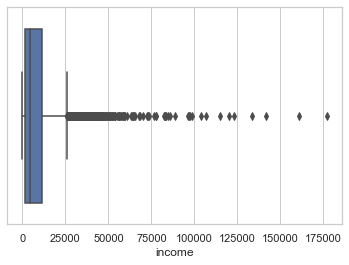

In [42]:
# regardons la distribution des revenus en 2008

sn.set_theme(style="whitegrid")
ax = sn.boxplot(x=Annee08["income"])

* On note beaucoup de outliers Il s'agit des revenus supérieurs à 25000 et allant jusqu'à 176928.550000 ce qui explique la différence observée entre la moyenne des revenu et le maximum

In [43]:
# récupération de la limite supérieure (dernier quantile) de notre boite à moustache
q = Annee08["income"].quantile(0.99)

In [44]:
# filtrage des revenus supérieurs à la limite supérieure
outliers = Annee08[Annee08["income"] > q]
outliers

,country,year_survey,quantile,nb_quantiles,income,gdpppp,ISO3,pays
399,AUT,2008,100,100,72216.680,36193.0,AUT,Autriche
599,BEL,2008,100,100,83104.470,33561.0,BEL,Belgique
1299,BRA,2008,100,100,59115.980,9559.0,BRA,Brésil
1593,CAN,2008,94,100,47541.620,35895.0,CAN,Canada
1594,CAN,2008,95,100,50099.023,35895.0,CAN,Canada
...,...,...,...,...,...,...,...,...
10995,USA,2008,97,100,77634.820,43261.0,USA,États-Unis
10996,USA,2008,98,100,88482.840,43261.0,USA,États-Unis
10997,USA,2008,99,100,106765.260,43261.0,USA,États-Unis
10998,USA,2008,100,100,176928.550,43261.0,USA,États-Unis


In [45]:
outliers['country'].unique()

array(['AUT', 'BEL', 'BRA', 'CAN', 'COL', 'CRI', 'CYP', 'DEU', 'DNK',
       'ESP', 'FIN', 'FRA', 'GBR', 'GRC', 'HND', 'IRL', 'IRN', 'ISL',
       'ISR', 'ITA', 'JPN', 'KOR', 'LUX', 'NLD', 'NOR', 'PRT', 'RUS',
       'SWE', 'TWN', 'URY', 'USA', 'ZAF'], dtype=object)

In [46]:
outliers.shape

(76, 8)

### Explorons la table contenant les Indices de GINI et la table *Meta data*

In [47]:
# explorons la table de l"indice de gini
gini.head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN,NaN,NaN


In [48]:
# supprimons la colonne indésirée *Unnamed: 65*
gini = gini.drop(columns= 'Unnamed: 65')

### Fichier Meta data

In [49]:
# explorons le fichier Meta dada
Data_gini.head(5)

,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
0,ABW,Latin America & Caribbean,High income,NaN,Aruba,NaN
1,AFE,NaN,NaN,"26 countries, stretching from the Red Sea in t...",Africa Eastern and Southern,NaN
2,AFG,South Asia,Low income,Fiscal year end: March 20; reporting period fo...,Afghanistan,NaN
3,AFW,NaN,NaN,"22 countries, stretching from the westernmost ...",Africa Western and Central,NaN
4,AGO,Sub-Saharan Africa,Lower middle income,NaN,Angola,NaN


In [50]:
# supprimmons la colonne Unnamed: 5
Data_gini = Data_gini.drop(columns = 'Unnamed: 5')

In [51]:
gini_2008=gini.copy()
# sélectionnons uniquement les indices de gini supérieur à 0 de 2007 à 2017
in_gini=gini_2008.loc[(gini_2008['2007']>0)&(gini_2008['2008']>0)&(gini_2008['2009']>0)
                    &(gini_2008['2010']>0)&(gini_2008['2011']>0)&(gini_2008['2012']>0)
                    &(gini_2008['2013']>0)&(gini_2008['2014']>0)&(gini_2008['2015']>0)
                    &(gini_2008['2016']>0)&(gini_2008['2017']>0),:]

In [52]:
# joignons les 2 tables  pour compléter les informations sur les indices de gini
new_gini=in_gini.merge(Data_gini, 
                         left_on=['Country Code'], 
                         right_on=['Country Code'])
new_gini.groupby(['IncomeGroup','Country Code']).sum()

1960  1961  1962  1963  1964  1965  1966  \
IncomeGroup         Country Code                                             
High income         AUT            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    BEL            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    CHE            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    CYP            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    CZE            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    DNK            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    ESP            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    EST            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    FIN            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    FRA            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    GBR            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    GRC            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    HUN            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    IRL            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    ISL            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    ITA            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    LTU            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    LUX            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    LVA            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    MLT            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    NLD            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    NOR            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    POL            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    PRT            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    SVN            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    SWE            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    URY            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    USA            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Lower middle income HND            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    IDN            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    KGZ            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    SLV            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    UKR            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Upper middle income ARM            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    BGR            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    BLR            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    CRI            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    DOM            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    ECU            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    GEO            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    KAZ            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    MDA            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    PAN            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    PER            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    PRY            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    ROU            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    RUS            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    THA            0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    TUR            0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                                  1967  1968  1969  ...

### Construisons une liste de pays de 5 à 10 sur lesquels nous nous baserons pour montrer la diversité des cas
**méthode choisi: kmeans**
<br/>

- Nous allons d'abord déterminer le nombre de classe optimal grâce à la méthode de la silhouette.

In [53]:
# Importons les modules necessaires pour réaliser le clustering
#from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples,silhouette_score


# quelques manipulations sur notre data
data_c= data_p7_fin.groupby(['pays']).mean()
data_clust = data_c[['income','gdpppp','Population']]

# standardisons nos données 
X_scaled = preprocessing.StandardScaler().fit_transform(data_clust)

Text(0.5, 1.0, 'silhouette score by number of clusters')

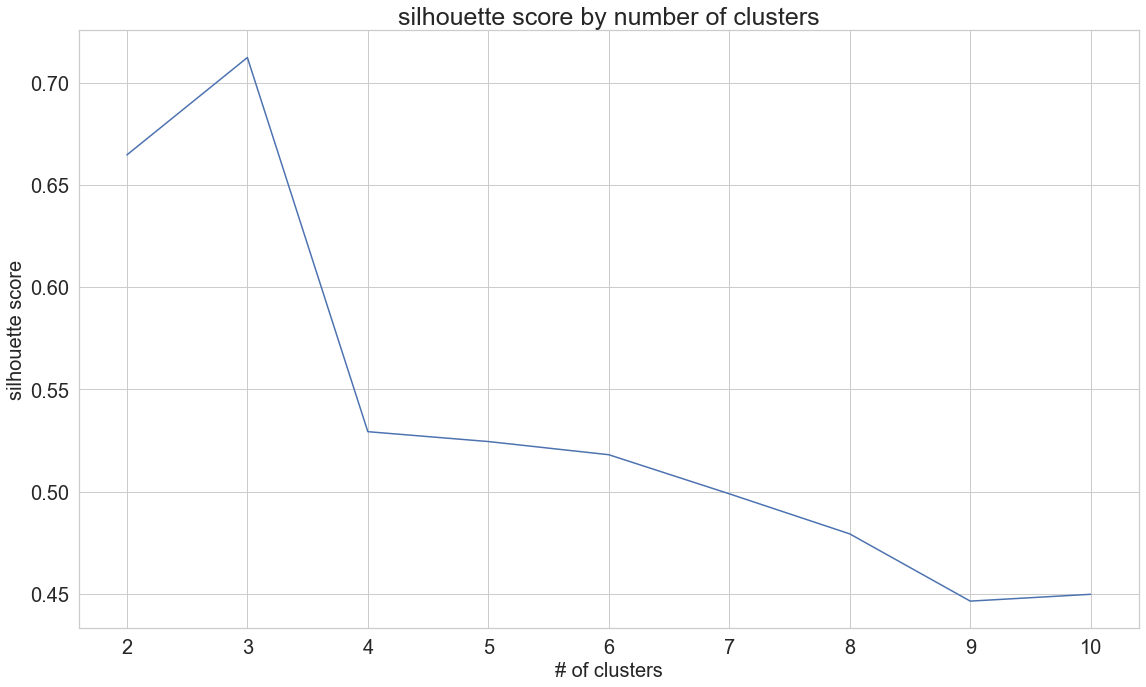

In [54]:
# détermination du nombre de cluster
def silhouette(x, kmax):
    sil=[None,None]
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters= k).fit(x)
        labels = kmeans.labels_
        sil.append(silhouette_score(x,labels,metric='euclidean'))
    return sil

fig= plt.figure(figsize=(19, 11))
ax = fig.add_subplot(1,1,1)
ax.tick_params(axis ='both',which = 'major', labelsize = 20)
ax.plot(silhouette(X_scaled,10))
ax.set_xlabel('# of clusters',fontsize = 20)
ax.set_ylabel('silhouette score', fontsize =20)
ax.set_title('silhouette score by number of clusters',fontsize = 25)
plt.savefig('graphique/silhouette_kmeans.png')
        

- Le nombre de cluster déterminer par la silhouette  est de 4

In [55]:
#CLUSTERING
kmeans = KMeans(n_clusters = 4)
kmeans.fit(X_scaled)
y_kmeans = kmeans.predict(X_scaled)


Text(0.5, 1.0, 'k_means clustering')

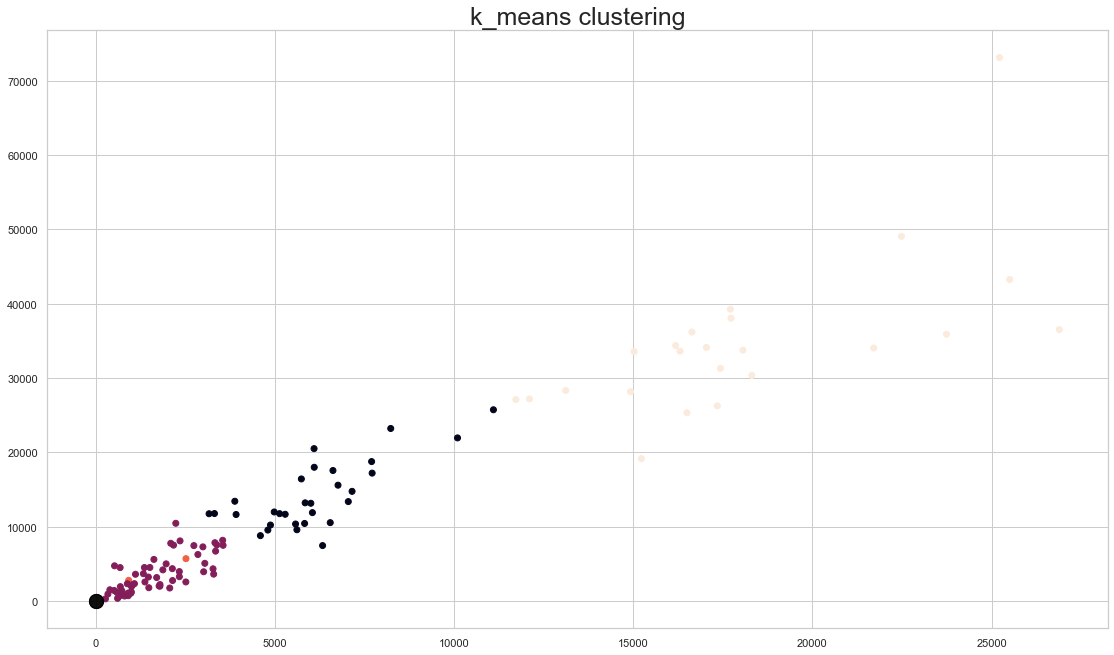

In [56]:
#Affichons le graphique représentant nos clusters
fig = plt.figure(figsize = (19,11))
ax = fig.add_subplot(1,1,1)
ax.scatter(data_clust['income'], data_clust['gdpppp'],c=y_kmeans)
cordo_centroides = kmeans.cluster_centers_
ax.scatter(cordo_centroides[:,0],cordo_centroides[:,1], c='black',s=200, alpha = 0.5);
ax.set_title('k_means clustering',fontsize = 25)

In [57]:
# bilan de chaque champs
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3]), array([30, 61,  2, 23], dtype=int64))

In [58]:
# affectons les labels des classes à nos données
data_clust['cluster']= kmeans.labels_

C:\Users\armel\AppData\Local\Temp/ipykernel_25280/4084193242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clust['cluster']= kmeans.labels_


In [59]:
parametre_pays = data_clust.reset_index()

In [60]:
parametre_pays.head(3)

,pays,income,gdpppp,Population,cluster
0,Afrique du Sud,5617.904880,9602.0,49779472.0,0
1,Albanie,2994.829902,7297.0,2947314.0,1
2,Allemagne,18061.718142,33758.0,82110097.0,3


### Appliquons l'analyse en composant principal

In [61]:

n_comp = 3

X = parametre_pays[['income','gdpppp','Population']].values
names = parametre_pays['pays'] # ou infos_pays.index pour avoir les intitulés
features = parametre_pays.columns
cluster = parametre_pays['cluster']

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Attribut du modèle PCA pour retrouver le pourcentage  de variance expliquée par chaque composante
pca.explained_variance_ratio_

# Retrouvons les coordonnées des composants principaux au niveau de chaque axe
pcs = pca.components_

### Nuage de point

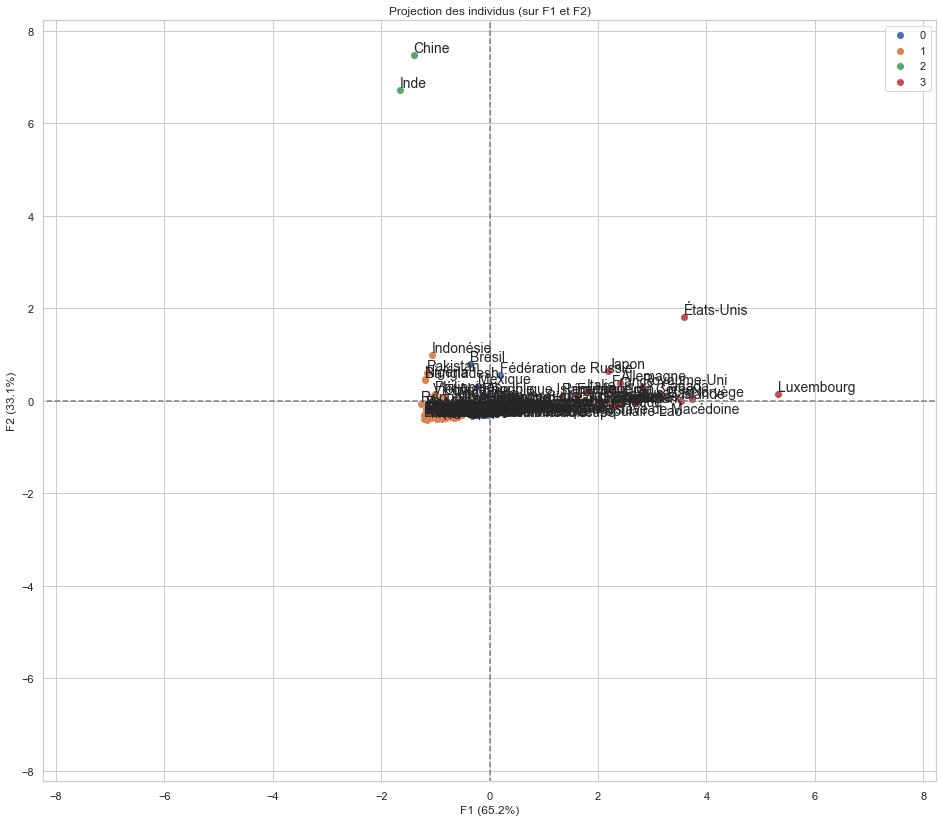

In [62]:
# Affichons le nuage des individus

X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)],labels = np.array(names),illustrative_var= np.array(cluster))

La Chine l'Inde et les USA et le Luxembourg sont trop éloignées nous les retirons du jeu de données et refaisons une autre classification.

#### Nouveau clustering : sans la Chine, le Luxembourg, l'Inde et les États-Unis

In [63]:
# créons notre nouvel échantillon sans les pays que nous avons identifiés excentriques
list_pays_ecart = ['Chine','Inde','États-Unis','Luxembourg']
new_data= data_p7_fin.loc[~data_p7_fin['pays'].isin(list_pays_ecart),:]
data_c= new_data.groupby(['pays']).mean()
data_clust1 = data_c[['income','gdpppp','Population']]


# standardisons de nouveau
X_scaled = preprocessing.StandardScaler().fit_transform(data_clust1)

In [64]:
# relaçons le clustering
kmeans = KMeans(n_clusters = 4)
kmeans.fit(X_scaled)
y_kmeans = kmeans.predict(X_scaled)

In [65]:
# bilan de chaque champs
np.unique(kmeans.labels_, return_counts=True)


(array([0, 1, 2, 3]), array([22, 26, 55,  9], dtype=int64))

In [66]:
# créons une nouvelle colonne cluster qui prendra pour entré les indicateurs de classe de pays
data_clust1['cluster']= kmeans.labels_
parametre_pays1 = data_clust1.reset_index()

C:\Users\armel\AppData\Local\Temp/ipykernel_25280/92364076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clust1['cluster']= kmeans.labels_


In [67]:
# Nouvelle ACP
n_comp = 3

X = parametre_pays1[['income','gdpppp','Population']].values
names = parametre_pays1['pays'] # ou infos_pays.index pour avoir les intitulés
features = parametre_pays1.columns
cluster = parametre_pays1['cluster']

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Attribut du modèle PCA pour retrouver le pourcentage  de variance expliquée par chaque composante
pca.explained_variance_ratio_

# Retrouvons les coordonnées des composants principaux au niveau de chaque axe
pcs = pca.components_

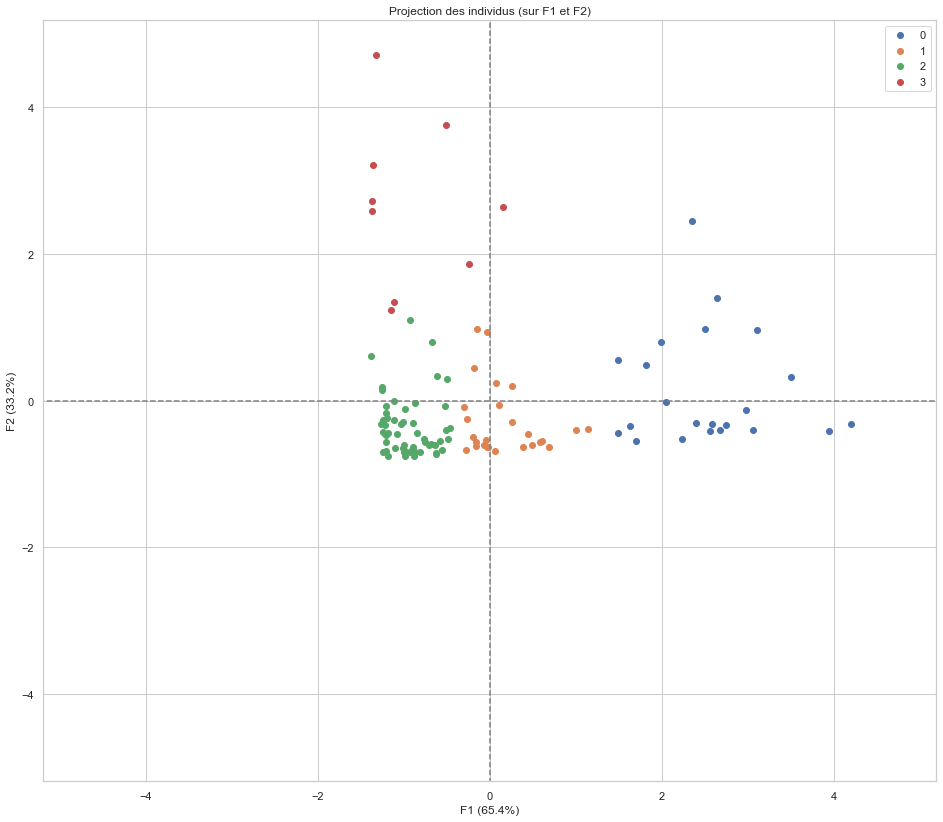

In [68]:
# Affichons le nuage des individus

X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var= np.array(cluster))

### Calcul des contributions des individus à l'inertie 

In [69]:

# Contribution des individus dans l'inertie totale
di = np.sum(X_scaled**2,axis=1) 
Contri_ind_iner = pd.DataFrame({'ID':names,'d_i':di})

Contri_ind_iner['cluster']= kmeans.labels_
Contri_ind_iner.sort_values(by='cluster',ascending =  False )

# exportons nos données
Contri_ind_iner.to_csv('data_export/contrib_clust.csv')

In [70]:
# En plus de la chine des Etats_unis, de l'Inde et du luxembourg, 
#nous avons choisi 1 pays par cluster selon que celui-ci contribut fortement à la formation du plan factoriel 

# liste des pays retenus
liste_pays=['IDN','FRA','LUX','CHN','EST','BLR','USA','IND','PAN','ISL']

# Mission 2

Montrez la diversité des pays en terme de distribution de revenus à l'aide d'un graphique.
Celui-ci représentera le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenus (axe des abscisses) pour 5 à 10 pays que vous aurez choisis pour montrer la diversité des cas.

- Représentez la courbe de Lorenz de chacun des pays choisis.

- Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans.

- Classez les pays par indice de Gini. Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. 
En quelle position se trouve la France ?

In [71]:
# extraction des données des pays de la short liste
data=data_p7_fin.copy()
echantillon=data.loc[(data['ISO3'].isin(liste_pays))]

## Montrez la diversité des pays en termes de distribution de revenus à l'aide d'un graphique.

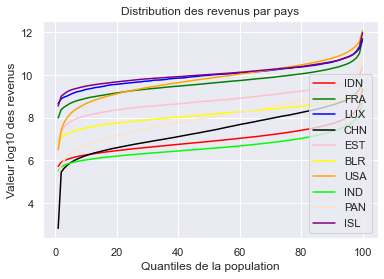

In [72]:
sn.set(style="darkgrid")
couleur=['red','green','blue','black','pink','yellow','orange','lime','bisque','purple']
liste_pays=['IDN','FRA','LUX','CHN','EST','BLR','USA','IND','PAN','ISL']

for i in range(len(liste_pays)):
    temporaire=data.loc[(data['ISO3']==liste_pays[i]),:]
    plt.plot(temporaire['quantile'],np.log(temporaire['income']),
             label=liste_pays[i],color=couleur[i])
plt.xlabel('Quantiles de la population')
plt.ylabel('Valeur log10 des revenus')    
plt.legend()
plt.title("Distribution des revenus par pays")

plt.savefig('graphiques/dist_revenus_pays.png')
plt.show()

Les revenus des populations sont distribués différement suivant les pays. 

* La Chine  par exemple a les plus bas revenu
* Les USA, la France et le luxembourg ont les revenus les plus élevé


## Traçons la courbe de lorenz

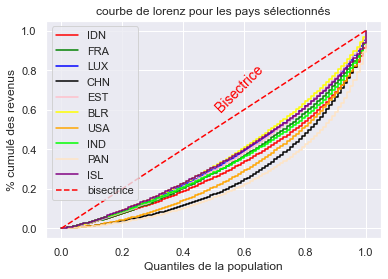

In [73]:
sn.set(style="darkgrid")
couleur=['red','green','blue','black','pink','yellow','orange','lime','bisque','purple']
#liste_pays=['IDN','FRA','LUX','CHN','EST','BLR','USA','IND','PAN','ISL']
for i in range(len(liste_pays)):
    temporaire=data.loc[(data['ISO3']==liste_pays[i]),:]
    depenses = temporaire[temporaire['income'] > 0]
    dep = temporaire['income'].values
    lorenz = np.cumsum(np.sort(dep)) / dep.sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0
    plt.plot(np.linspace(0,1,len(lorenz)),lorenz,drawstyle='steps-post',
         label=liste_pays[i],color=couleur[i])
    # Paramètre de la bisectrice
x = [0, 1]
y = [0, 1]
plt.plot(x, y, 'red', linestyle='--', label='bisectrice')
plt.text(0.5, 0.59, 'Bisectrice', fontsize=14, rotation = 45, color ='red')

plt.xlabel('Quantiles de la population')
plt.ylabel('% cumulé des revenus')
plt.legend()
plt.title("courbe de lorenz pour les pays sélectionnés")
plt.savefig('graphiques/courbes-lorenz_pays.png')
plt.show()

* Pour ces pays choisis, les revenus sont assez inégalement réparti 
La bulgarie et l'Islande tendent vers une égalité alors que le Panama et la Chine ont des répartitions de revenu inégales car leur courbe de lorenz sont éloigne de la premnière bissectrice.


## Indice de Gini
### évolution des indices de Gini des pays sélectionnés suivant les années

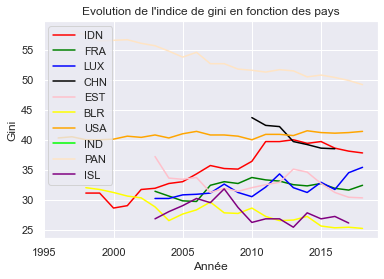

In [74]:
sn.set(style="darkgrid")
couleur=['red','green','blue','black','pink','yellow','orange','lime','bisque','purple']
liste_pays=['IDN','FRA','LUX','CHN','EST','BLR','USA','IND','PAN','ISL']
annee=['1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018']
anne_int = [int(i) for i in annee]
for i in range(len(liste_pays)):
    temporaire=gini.loc[(gini['Country Code']==liste_pays[i]),annee].transpose()
    plt.plot(anne_int,temporaire,label=liste_pays[i],color=couleur[i])
plt.xlabel('Année')
plt.ylabel('Gini')
plt.legend()
plt.title("Evolution de l'indice de gini en fonction des pays")
plt. savefig('graphiques/ evolution_Indice_gini.png')
plt.show()

###  l'évolution de l'indice de Gini suivant les années confirme que:
- le Panama a des revenus distribués inégalitairement car son indice de gini vari entre 58 et 48.
- la Bulagarie et l'Islande ont des indice de Gini très bas ce qui confirme les courbes de lorenz des revenus de ces pays 


### Générons  les indices de gini qui manquent dans notre jeu de données

In [75]:
liste_pays1=data_p7_fin['pays'].unique()

In [76]:
gini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 65 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            0 non-null      float64
 5   1961            0 non-null      float64
 6   1962            0 non-null      float64
 7   1963            0 non-null      float64
 8   1964            0 non-null      float64
 9   1965            0 non-null      float64
 10  1966            0 non-null      float64
 11  1967            1 non-null      float64
 12  1968            0 non-null      float64
 13  1969            1 non-null      float64
 14  1970            0 non-null      float64
 15  1971            1 non-null      float64
 16  1972            0 non-null      float64
 17  1973            0 non-null      flo

In [77]:
# Utilisons notre data et la courbe de lorenz pour générer les indice de Gini des pays manquants

for i in range(len(liste_pays1)):
    temporaire=data_p7_fin.loc[(data_p7_fin['pays']==liste_pays1[i]),:]
    depenses = temporaire[temporaire['income'] > 0]
    dep = temporaire['income'].values
    lorenz = np.cumsum(np.sort(dep)) / dep.sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0
    #indice de gini 
    #Ici on peut voir que 5%-10% des clients font 25% du CA, puisque notre courbe remonte de manière anormale
    aire_ss_courbe = lorenz[:-1].sum()/len(lorenz) 
    # aire sous la courbe de Lorenz. La dernière valeur ne participe pas à l'aire, d'où "[:-1]"
    S = 0.5 - aire_ss_courbe # aire entre la 1e bissectrice et la courbe de Lorenz
    gini1 = 2*S
    data_p7_fin.loc[data_p7_fin['pays']==liste_pays1[i],'gini']=gini1


In [78]:
# Affichons la data complétée par l'indice Gini
data_p7_fin.head(5)

,pays,quantile,nb_quantiles,income,gdpppp,ISO3,Population,year_survey,gini
0,Albanie,1,100,728.89795,7297.0,ALB,2947314.0,2008,0.32141
1,Albanie,2,100,916.66235,7297.0,ALB,2947314.0,2008,0.32141
2,Albanie,3,100,1010.91600,7297.0,ALB,2947314.0,2008,0.32141
3,Albanie,4,100,1086.90780,7297.0,ALB,2947314.0,2008,0.32141
4,Albanie,5,100,1132.69970,7297.0,ALB,2947314.0,2008,0.32141


In [79]:
data_p7_fin['year_survey'].unique()

array([2008, 2009, 2010, 2007, 2006, 2011, 2004], dtype=int64)

In [80]:
# sélectionnons uniquement l'année 2008
gini_2008=data_p7_fin.loc[(data_p7_fin['year_survey']==2008),:]

In [81]:
gini_2008[gini_2008.duplicated()]

,pays,quantile,nb_quantiles,income,gdpppp,ISO3,Population,year_survey,gini


In [82]:
# supprimons les doublons
gini_2008.drop_duplicates(subset ="pays", 
                     keep = 'first', inplace = True) 

C:\Users\armel\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [83]:
gini_2008.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 0 to 11499
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pays          76 non-null     object 
 1   quantile      76 non-null     int64  
 2   nb_quantiles  76 non-null     int64  
 3   income        76 non-null     float64
 4   gdpppp        76 non-null     float64
 5   ISO3          76 non-null     object 
 6   Population    76 non-null     float64
 7   year_survey   76 non-null     int64  
 8   gini          76 non-null     float64
dtypes: float64(4), int64(3), object(2)
memory usage: 5.9+ KB


#### Classons nos pays en fonction de leur indice de Gini

In [84]:
# créons une nouvelle colonne RANK qui donne le rang de l'index après tri
gini_2008['RANK']=gini_2008['gini'].rank()

C:\Users\armel\AppData\Local\Temp/ipykernel_25280/3375523249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gini_2008['RANK']=gini_2008['gini'].rank()


In [85]:
# classons les pays par ordre croissant d'indice de gini
gini_2008.sort_values(by = ['gini'],ascending=True).head(n=5)

,pays,quantile,nb_quantiles,income,gdpppp,ISO3,Population,year_survey,gini,RANK
9599,Slovénie,1,100,2814.95300,27197.0,SVN,2021316.0,2008,0.248249,1.0
9499,Slovaquie,1,100,791.46204,20515.0,SVK,5379233.0,2008,0.264573,2.0
2300,République Tchèque,1,100,1586.24710,23223.0,CZE,10384603.0,2008,0.270162,3.0
9699,Suède,1,100,2284.43290,34371.0,SWE,9219637.0,2008,0.272166,4.0
10699,Ukraine,1,100,942.38495,6721.0,UKR,46258189.0,2008,0.272415,5.0


In [86]:
gini_2008.describe()

,quantile,nb_quantiles,income,gdpppp,Population,year_survey,gini,RANK
count,76.0,76.0,76.000000,76.000000,7.600000e+01,76.0,76.000000,76.000000
mean,1.0,100.0,1032.515696,17045.766185,3.060868e+07,2008.0,0.383512,38.500000
std,0.0,0.0,1258.508479,14023.297305,5.039408e+07,0.0,0.097282,22.083176
min,1.0,100.0,17.317732,303.193050,3.174140e+05,2008.0,0.248249,1.000000
25%,1.0,100.0,184.005360,7153.000000,4.424768e+06,2008.0,0.309255,19.750000
50%,1.0,100.0,562.762450,11843.000000,9.624721e+06,2008.0,0.352600,38.500000
75%,1.0,100.0,1254.310250,27141.500000,3.861436e+07,2008.0,0.444669,57.250000
max,1.0,100.0,5780.837400,73127.000000,3.040940e+08,2008.0,0.682949,76.000000


In [87]:
# classons les pays par ordre décroissant d'indice de Gini
gini_2008.sort_values(by = ['gini'],ascending=False).head(n=5)

,pays,quantile,nb_quantiles,income,gdpppp,ISO3,Population,year_survey,gini,RANK
11399,Afrique du Sud,1,100,60.490383,9602.0,ZAF,49779472.0,2008,0.682949,76.0
4000,Honduras,1,100,50.166843,3628.0,HND,7980955.0,2008,0.615512,75.0
2000,Colombie,1,100,62.605060,8185.0,COL,44254972.0,2008,0.583437,74.0
1400,République Centrafricaine,1,100,40.928130,685.0,CAF,4273368.0,2008,0.575972,73.0
1100,Bolivie,1,100,20.584948,3950.0,BOL,9721457.0,2008,0.575719,72.0


In [88]:
# Trouvons la position de l'indice de Gini de la France 
gini_2008.loc[gini_2008['ISO3']=='FRA',:]

,pays,quantile,nb_quantiles,income,gdpppp,ISO3,Population,year_survey,gini,RANK
3300,France,1,100,2958.304,30357.0,FRA,64374979.0,2008,0.34564,35.0


### les 5 pays ayant l'indice de Gini le plus faible
* SVN, SVK, CZE, SWE, UKR

 ### les 5 pays ayant l'indice de Gini le plus faible
 * ZAK, HND, COL, CAF, BOL

### Position de la France dans le classement des indices de Gini
* La France a l'indice de gini n0 35

# Mission 3
Nous avons à ce stade 2 des 3 variables explicaives souhaitées
- mj = le revenus moyens du pays j
- Gj = l'indice de Gini du pays j
Il faut maintenant trouver pour un individus la classe de revenus de ses parents Ci_parent.
Nous trouverons cette classe de parent grace à un coefficient mesurant la corrélation entre le revenu de l'individu et le revenu de ses parents.Ce coefficient sera ici appelé **coefficient d'élasticité**., il mesure la mobilité intergénérationnelle du revenu.
 

- Nous utiliserons le code fourni dans le libelé du projet pour réaliser les questions 1 à 6

In [89]:
# travaillons à présent sur le fichier GDIMMAY2018
GDIMMAY2018.head(2)

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.1
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.1


In [90]:
# affichons ses colonnes
GDIMMAY2018.columns

Index(['countryname', 'wbcode', 'iso3', 'region', 'incgroup2', 'incgroup4',
       'fragile', 'survey', 'year', 'status', 'cohort', 'parent', 'child',
       'obs', 'P1', 'P2', 'P3', 'P4', 'P5', 'C1', 'C2', 'C3', 'C4', 'C5',
       'MEANp', 'MEANc', 'SDp', 'SDc', 'GINIp', 'GINIc', 'IGP', 'NL1', 'NL2',
       'COR', 'MAcatM', 'MAcatC1', 'Q4_IGpri', 'BHQ1', 'BHQ2', 'BHQ3', 'BHQ4',
       'Q4BH', 'Q4child', 'Delta50', 'Asher_Q4_IGpri', 'ThreeGen_obs',
       'ThreeGen_IGPp1', 'ThreeGen_IGPg1', 'ThreeGen_IGPgsd', 'All2125_MEANp',
       'All2125_MEANc', 'All2125_IGP', 'All2125_MAcatC1', 'Cores2125_MEANp',
       'Cores2125_MEANc', 'Cores2125_IGP', 'Cores2125_MAcatC1',
       'Shortfall0611_obs', 'Shortfall0611_IGP', 'Shortfall1217_obs',
       'Shortfall1217_IGP', 'IGEincome', 'S1', 'S2', 'S3', 'MLD_psu'],
      dtype='object')

In [91]:
# affichage des années de notre data
GDIMMAY2018['year'].unique()

array([1980, 1940, 1950, 1960, 1970], dtype=int64)

In [92]:
#aggrégation par code ISO,region et groupe de revenu
search_elast=GDIMMAY2018.groupby(['iso3','region','incgroup4']). mean().reset_index()
print(search_elast.shape)

(150, 59)


In [93]:
# moyenne des IGEincome groupé par region et niveau de revenu
search_elast=search_elast[['iso3','region','incgroup4','IGEincome']]
mean_elast=search_elast.groupby(['region','incgroup4']).mean().reset_index()
mean_elast

,region,incgroup4,IGEincome
0,East Asia & Pacific,Lower middle income,0.527665
1,East Asia & Pacific,Upper middle income,0.469500
2,Europe & Central Asia,Lower middle income,0.424817
3,Europe & Central Asia,Upper middle income,0.477171
4,High income,High income,0.346163
5,Latin America & Caribbean,Lower middle income,0.940737
6,Latin America & Caribbean,Upper middle income,0.878852
7,Middle East & North Africa,Lower middle income,0.916461
8,Middle East & North Africa,Upper middle income,0.517397
9,South Asia,Low income,0.436000


In [94]:
# Affichons les valeurs manquantes des variables
mean_elast.isnull().sum()

region       0
incgroup4    0
IGEincome    1
dtype: int64

- On note 1 valeur manquante pour le coefficient d'élasticité (IGEincome).
* cette valeur manquante appartient à la classe Upper middle income nous trouverons donc la moyenne de cette classe pour l'imputer à la valeur manquante.

In [95]:
# trouvons la moyenne des coefficients pour Upper middle income
mean_elast.loc[mean_elast['incgroup4']=='Upper middle income','IGEincome'].mean()

0.6039841697142857

In [96]:
#complétons la valeur manquante  des coeficients d'elasticité par leur moyenne(il s'agit de la moyenne du groupe de revenu auxquels les pays appartiennent)
# l'asie du sud appartient au Upper middle income
mean_elast.loc[mean_elast['IGEincome'].isnull(),'IGEincome']=0.603984 

In [97]:
# Affichons notre data
mean_elast

,region,incgroup4,IGEincome
0,East Asia & Pacific,Lower middle income,0.527665
1,East Asia & Pacific,Upper middle income,0.469500
2,Europe & Central Asia,Lower middle income,0.424817
3,Europe & Central Asia,Upper middle income,0.477171
4,High income,High income,0.346163
5,Latin America & Caribbean,Lower middle income,0.940737
6,Latin America & Caribbean,Upper middle income,0.878852
7,Middle East & North Africa,Lower middle income,0.916461
8,Middle East & North Africa,Upper middle income,0.517397
9,South Asia,Low income,0.436000


In [98]:
# joingnos nos tables
final_elas=search_elast.merge(mean_elast,
                            on=['region','incgroup4'],
                           suffixes=('_nor', '_moy'))
final_elas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   iso3           150 non-null    object 
 1   region         150 non-null    object 
 2   incgroup4      150 non-null    object 
 3   IGEincome_nor  75 non-null     float64
 4   IGEincome_moy  150 non-null    float64
dtypes: float64(2), object(3)
memory usage: 7.0+ KB


- **IGEincome_nor** compte 75 valeurs manquantes nous les complèterons par les moyennes contenues dans la colonne **IGEincome_moy**

In [99]:
# exportons la dataframe final pour les données de l'élasticité en CSV
final_elas.to_csv('data_p7/final_elas.csv')

In [100]:
# sélection des colonnes
final_elas=final_elas[['iso3','IGEincome_moy','IGEincome_nor']] # IGEincome_nor designe (valeurs normales) et IGEincome_moy(coef d'élast moyen des classes de revenu)
final_elas.head(5)

,iso3,IGEincome_moy,IGEincome_nor
0,AFG,0.436,NaN
1,NPL,0.436,0.436
2,AGO,0.677,NaN
3,BWA,0.677,NaN
4,GAB,0.677,NaN


In [101]:
final_elas.loc[final_elas['iso3']=='XKX',:]

,iso3,IGEincome_moy,IGEincome_nor


In [102]:
# groupons par code ISO3
final_elas.groupby(['iso3']).mean().head(n=6)

,IGEincome_moy,IGEincome_nor
iso3,,
AFG,0.436000,NaN
AGO,0.677000,NaN
ALB,0.477171,0.815874
ARG,0.878852,NaN
ARM,0.424817,NaN
AUS,0.346163,0.275000


In [103]:
# Remplacons les valeurs manquantes de *IGEincome_nor* par leur correspondant  *IGEincome_moy*
final_elas.loc[final_elas['IGEincome_nor'].isnull()
               ,'IGEincome_nor']=final_elas.loc[final_elas['IGEincome_nor'].isnull(),
                                                'IGEincome_moy']

In [104]:
final_elas.head(n=4)

,iso3,IGEincome_moy,IGEincome_nor
0,AFG,0.436,0.436
1,NPL,0.436,0.436
2,AGO,0.677,0.677
3,BWA,0.677,0.677


In [105]:
final_elas.info() # vérifions qu'il n'y a plus de valeurs manquantes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   iso3           150 non-null    object 
 1   IGEincome_moy  150 non-null    float64
 2   IGEincome_nor  150 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.7+ KB


In [106]:
# groupons encore par code ISO3 pour vérifier que tout à bien fonctionné
final_elas.groupby(['iso3']).mean().head(n=6)

,IGEincome_moy,IGEincome_nor
iso3,,
AFG,0.436000,0.436000
AGO,0.677000,0.677000
ALB,0.477171,0.815874
ARG,0.878852,0.878852
ARM,0.424817,0.424817
AUS,0.346163,0.275000


In [107]:
# ajoutons les données pour le coef d'elasticité *final_elas* dans notre table générale *data_p7_fin*
dataset_final=data_p7_fin.merge(final_elas,how='left', 
                         left_on=['ISO3'], 
                         right_on=['iso3'])


In [108]:
# sélection des colonnes. nous ne prendrons pas l'année et IGEincome_moy
dataset_final= dataset_final[['pays','quantile','nb_quantiles','income','gdpppp','gini','IGEincome_nor']]

In [109]:
# Renommons la colonnes *IGEincome_nor* en *coef_elast*
dataset_final = dataset_final.rename({'IGEincome_nor':'coef_elast'}, axis=1)

In [110]:
dataset_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11600 entries, 0 to 11599
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pays          11600 non-null  object 
 1   quantile      11600 non-null  int64  
 2   nb_quantiles  11600 non-null  int64  
 3   income        11600 non-null  float64
 4   gdpppp        11600 non-null  float64
 5   gini          11600 non-null  float64
 6   coef_elast    11400 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 725.0+ KB


In [111]:
# plusieurs valeurs manquantes pour le coefficient d'élasticité au lieu de 11600 on a 11400
dataset_final.loc[dataset_final['coef_elast'].isnull(),:] # Il s'agit de XKX et SYR

,pays,quantile,nb_quantiles,income,gdpppp,gini,coef_elast
5800,Kosovo,1,100,437.89370,7530.632,0.331163,NaN
5801,Kosovo,2,100,508.17133,7530.632,0.331163,NaN
5802,Kosovo,3,100,591.82820,7530.632,0.331163,NaN
5803,Kosovo,4,100,668.00000,7530.632,0.331163,NaN
5804,Kosovo,5,100,730.40220,7530.632,0.331163,NaN
...,...,...,...,...,...,...,...
9994,République Arabe Syrienne,96,100,1702.83960,4512.000,0.373873,NaN
9995,République Arabe Syrienne,97,100,1883.93970,4512.000,0.373873,NaN
9996,République Arabe Syrienne,98,100,2157.02400,4512.000,0.373873,NaN
9997,République Arabe Syrienne,99,100,2622.62130,4512.000,0.373873,NaN


In [112]:
# retirons ces pays dont il manque des valeurs pour le coefficient d'élasticité
dataset_final=dataset_final.loc[~dataset_final['coef_elast'].isnull(),:]

In [113]:
dataset_final.head(3)

,pays,quantile,nb_quantiles,income,gdpppp,gini,coef_elast
0,Albanie,1,100,728.89795,7297.0,0.32141,0.815874
1,Albanie,2,100,916.66235,7297.0,0.32141,0.815874
2,Albanie,3,100,1010.91600,7297.0,0.32141,0.815874


In [114]:
# vérifions qu'il n'existe plus de valeur manquante pour le coefficient d'élasticité
dataset_final.loc[dataset_final['coef_elast'].isnull(),:]

,pays,quantile,nb_quantiles,income,gdpppp,gini,coef_elast


In [115]:
# vérifions que le kosovo a bien été enlevé de notre table
dataset_final.loc[dataset_final['pays']=="XKX"]

,pays,quantile,nb_quantiles,income,gdpppp,gini,coef_elast


### Code pour générer les revenus et les probabilités conditionnelles

   ### Question1. 
    
Générez un grand nombre de réalisation d'une variable que nous appellerons
selon une loi normale. Le choix de la moyenne et de l'écart-type n'auront pas d'incidence sur le
résultat final. doit être supérieur à 1000 fois le nombre de quantiles

In [116]:
#  Définition des paramètres
nb_quantiles = 10
n = 1000 * nb_quantiles
pj = 0.9

# Génération selon la loi Normale
ln_y_parent = st.norm(0,1).rvs(size=n)
ln_y_parent

array([ 0.23715089, -1.22552719,  0.48911656, ..., -1.90202907,
       -0.26542289,  1.36994454])

 ### Question 2
 
Générez n réalisations du terme d'erreur ϵ selon une loi normale de moyenne 0 et d'écart-type1.


In [117]:
# Sachant n nous pouvons avoir les erreur selon une loi normale
residus = st.norm(0,1).rvs(size=n)  

### Question 3

Calculons le revenus des enfants **y_child** pour une valeur de pj donnée(pj = 0,9)
Nous calculerons aussi le revenus des parents **y_parent**

In [118]:
# Calcul des revenus des parents et des enfants
y_child = np.exp(pj * ln_y_parent + residus)
y_parents = np.exp(ln_y_parent)

# Conversion des tableaux en series
y_child = pd.Series(y_child)
y_parents = pd.Series(y_parents)

### Question 4
Calculons la classe de revenu des enfants (Ci_child) et la classe de revenu parent (Ci_parent) pour chacun des n individus générés. nous utiliserons les revenus parents et enfant (ychild et yparent)

In [119]:
# Déterminons la classe de revenus des enfants
size_child = len(y_child)
l_sorted_child = y_child.copy()
l_sorted_child = l_sorted_child.sort_values()
quantiles_child = np.round(np.arange(1,
                                     nb_quantiles + 1,
                                     nb_quantiles / size_child) - 0.5 + 1./size_child)
q_dict_child = {a: int(b) for a, b in zip(l_sorted_child, quantiles_child)}
c_i_child = pd.Series(q_dict_child[e] for e in  y_child)

# Détermination de la classe de revenus des parents
size_parents = len(y_parents)
l_sorted_parents = y_parents.copy()
l_sorted_parents = l_sorted_parents.sort_values()
quantiles_parents = np.round(np.arange(1,
                                       nb_quantiles + 1,
                                       nb_quantiles / size_parents) - 0.5 + 1./size_parents)
q_dict_parents = {a: int(b) for a, b in zip(l_sorted_parents, quantiles_parents)}
c_i_parent = pd.Series(q_dict_parents[e] for e in  y_parents)

# Mise en forme
sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis = 1)
sample.columns = ['y_child', 'y_parents', 'c_i_child', 'c_i_parent']

In [120]:
#Affichons la data contenant les revenus parents,enfants et leur classe de revenus générés
sample.head()

,y_child,y_parents,c_i_child,c_i_parent
0,0.163621,1.267632,1,6
1,0.362857,0.293603,3,2
2,0.904835,1.630875,5,7
3,0.798752,1.487126,5,7
4,1.833086,3.505992,7,9


### Question 5: Exprimons les distributions conditionnelles
Pour chaque classe enfant (Ci_child) exprimons la distribution conditionnelle (Ci_parent)


In [121]:

from collections import Counter

def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample
# ici On divise le nombre d'individus compté par le nombre d'individus total pour chaque quantile parent

def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()

    if total == 0 :
         return [0] * nb_quantiles

    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib 

# Ensuite pour chaque quantile enfant, on crée la ligne de distribution du c_i_parent
def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len) # on a trouve le nombre d'individus qui la meme classe parent
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat)

def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure()

    cumul = np.array([0] * nb_quantiles)

    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label= str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)
    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.savefig('graphiques/distribut_condi.png')
    plt.show()



In [122]:
# Affectation du résultat des opérations réalisées par la fonction conditional_distributions() dans la variable cd
cd= conditional_distributions(sample, nb_quantiles)

In [123]:
print(cd)

[[0.445 0.233 0.128 0.085 0.048 0.034 0.017 0.007 0.002 0.001]
 [0.221 0.201 0.182 0.122 0.101 0.077 0.056 0.025 0.012 0.003]
 [0.118 0.174 0.162 0.153 0.123 0.102 0.06  0.055 0.042 0.011]
 [0.084 0.152 0.137 0.12  0.148 0.106 0.106 0.08  0.049 0.018]
 [0.062 0.089 0.127 0.143 0.131 0.134 0.12  0.093 0.066 0.035]
 [0.033 0.058 0.098 0.125 0.119 0.154 0.135 0.117 0.108 0.053]
 [0.024 0.034 0.074 0.102 0.111 0.134 0.138 0.16  0.13  0.093]
 [0.006 0.039 0.055 0.076 0.107 0.135 0.151 0.144 0.173 0.114]
 [0.007 0.016 0.03  0.059 0.083 0.081 0.124 0.173 0.206 0.221]
 [0.    0.004 0.007 0.015 0.029 0.043 0.093 0.146 0.212 0.451]]


### Question 6 et  Question 7: 
* Graphique repésentant les distributions conditionnelles à faible et forte mobilité  
* Calcul des probabilités conditionnelles pour chaque cas 
Prenons 2 exemples 
- Ci_parent = 8 , et Ci_child = 5 
- Ci_parent = 2 , et Ci_child = 6

In [124]:
#### Cas d'une faible mobilité

In [125]:
# cas d'une faible mobilité: pj=0,9
#cd= conditional_distributions(sample, nb_quantiles)
#plot_conditional_distributions(pj, cd, nb_quantiles)

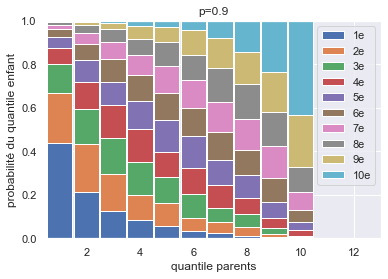

<Figure size 432x288 with 0 Axes>

In [126]:
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]
pj = 0.9 # coefficient d'élasticité du pays j
#nb_quantiles = 100 # nombre de quantiles (nombre de classes de revenu)
n = 1000*nb_quantiles # taille de l'échantillon
y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
plot_conditional_distributions(pj, cd, nb_quantiles) # Cette instruction prendra du temps si nb_quantiles > 10
plt.savefig('graphiques/exemple_faible_mobi.png')
plt.show()



In [127]:
# calcul de la probabilité conditionne cas d'une faible mobilite
# exemple 1
# créons un dataframe de la distribution conditionnelle pour Pj=0,9
pd.DataFrame(cd,index=np.arange(1,11,1),columns= np.arange(1,11,1))

c_i_child = 5
c_i_parent = 8
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child,pj, p))


P(c_i_parent = 8 | c_i_child = 5, pj = 0.9) = 0.114


In [128]:
# Autre exemple
#print(cd)
c_i_child = 6
c_i_parent = 2
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child,pj, p))


P(c_i_parent = 2 | c_i_child = 6, pj = 0.9) = 0.077


#### Cas d'une forte mobilité

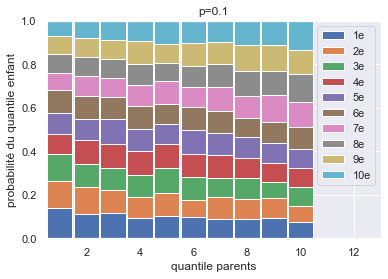

<Figure size 432x288 with 0 Axes>

In [129]:
# définissons les nouveaux paramètres pour le cas d'une forte mobilité:
pj1 = 0.1
y_child1, y_parents1 = generate_incomes(n, pj1)
sample1 = compute_quantiles(y_child1, y_parents1, nb_quantiles)
cd1 = conditional_distributions(sample1, nb_quantiles)
#cd1

plot_conditional_distributions(pj1, cd1, nb_quantiles)
plt.savefig('graphiques/exemple_forte_mobi.png')
plt.show()


In [130]:
# créons un dataframe de la distribution conditionnelle pour Pj=0,1
pd.DataFrame(cd1,index=np.arange(1,11,1),columns= np.arange(1,11,1))

,1,2,3,4,5,6,7,8,9,10
1,0.137,0.112,0.117,0.094,0.102,0.096,0.088,0.089,0.092,0.073
2,0.128,0.123,0.103,0.098,0.108,0.079,0.104,0.091,0.092,0.074
3,0.121,0.105,0.102,0.098,0.115,0.108,0.087,0.098,0.077,0.089
4,0.093,0.111,0.113,0.109,0.107,0.104,0.102,0.090,0.083,0.088
5,0.099,0.096,0.113,0.105,0.094,0.111,0.102,0.097,0.095,0.088
6,0.102,0.108,0.100,0.103,0.091,0.106,0.104,0.090,0.096,0.100
7,0.080,0.089,0.088,0.097,0.108,0.091,0.107,0.101,0.123,0.116
8,0.086,0.088,0.087,0.099,0.081,0.098,0.107,0.114,0.112,0.128
9,0.083,0.088,0.088,0.104,0.086,0.103,0.100,0.118,0.118,0.112
10,0.071,0.080,0.089,0.093,0.108,0.104,0.099,0.112,0.112,0.132


In [131]:
#Calculons cette probabilité conditionnelle dans le cas d'une faible mobilité
#print(cd1)
c_i_child1 = 5
c_i_parent1 = 8
p = proba_cond(c_i_parent, c_i_child, cd1)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child,pj1, p))


P(c_i_parent = 2 | c_i_child = 6, pj = 0.1) = 0.088


In [132]:
# Autre exemple
#print(cd1)
c_i_child1 = 6
c_i_parent1 = 2
p = proba_cond(c_i_parent, c_i_child, cd1)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child,pj1, p))


P(c_i_parent = 2 | c_i_child = 6, pj = 0.1) = 0.088


#### Question 8. Créons 499 clones de l'echantillon extrait de la world Income Dictribution (WID)

Nous allons maintenant travailler sur un nouvel échantillon. Celui-ci sera créé à partir de la WID. Pour chaque individu de la Wold Income Distribution, créez-en 499 "clones". La taille de votre nouvel échantillon sera donc 500 fois plus grand que celui de la Wold Income Distribution.


In [133]:
# créons un nouvel échantillon plus grand en multipliant notre Dataset par 500
# Nous utiliserons la methode pd.concat pour ajouter des lignes à notre dataset
big_data = pd.concat([dataset_final]*500, ignore_index=True)

In [134]:
big_data.shape

(5700000, 7)

In [135]:
print('{}*500 = {} '.format(dataset_final.shape[0], big_data.shape[0]))

11400*500 = 5700000 


In [136]:
# prenons l'exemple d'un pays 
big_data.loc[big_data['pays']=='Albanie',:].shape

(50000, 7)

### Question 9. Attribuons au individus crées leur classe parent correspondante

Attribuons aux 500 individus crées par pays et classe d'enfant leur classe de revenu parent conformément aux distributions trouvées plus haut.

In [137]:
# Classons par ordre alphabétic de pays et ordre de quantile
big_data=big_data.sort_values(by=['pays','quantile']).reset_index()

In [140]:

#ce code pour générer les classes des parent des clones formés prend trop de temps à s'exécuter


list_pays =big_data['pays'].unique()
classe_parent=0
classe_enfant=0
list_prob=[]

  # Pour chaque pays
for pays in list_pays:
    # Selection du pays sélectionnons son coefficient d'élasticité
    pj=big_data.loc[big_data['pays']==pays,'coef_elast'].iloc[0]
    nb_quantiles = 100 # nombre de quantiles (nombre de classes de revenu)
    n = 50000 # taille de l'échantillon
    y_child, y_parents = generate_incomes(n, pj)
    sample = compute_quantiles(y_child, y_parents, nb_quantiles)
    cd = conditional_distributions(sample, nb_quantiles)
    for c_i_child in range(100):
        for c_i_parent in range(100):
            p = proba_cond(c_i_parent, c_i_child, cd)
            #print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child,pj,p))
            list_prob.extend([c_i_parent+1]*(int(p*500)))


In [141]:
len(list_prob)# affichons la longueur de la serie de classe de parent générée

5700000

In [142]:
# Affichons cette liste de classe
list_prob

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,


In [143]:
# créons une colonne dans laquelle nous stoquons les classes parents obtenues
big_data['Ci_parent']=list_prob

In [144]:
big_data['pays'].unique().shape # Nous avons bien 114 pays sur la liste sachant que la syr et xkx ont été suprimés

(114,)

### Question 11
Vérifions que notre nouvel échantillon contient bien les 2 variables explicatives initiales mj et Gj

In [145]:
# Affichons simplement cette table
big_data.sample()

,index,pays,quantile,nb_quantiles,income,gdpppp,gini,coef_elast,Ci_parent
3706546,532612,Pakistan,14,100,463.8931,2335.0,0.316769,0.4505,7


In [146]:
# Exportons notre base de donnée en csv
big_data.to_csv("Data_P7/big_data.csv")

# Mission 4

Pour cette mission 4, nous chercherons à expliquer le revenu des individus en fonction de plusieurs
variables explicatives : le pays de l'individu, l'indice de Gini de ce pays, la classe de revenus des
parents, etc

In [148]:
# Sélectionnons les colonnes utiles
big_data=big_data[[ 'pays', 'quantile',
       'income', 'gini', 'coef_elast', 'Ci_parent']]

In [150]:
data_anova =big_data.groupby(['pays','quantile']).mean().reset_index()
data_anova.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11400 entries, 0 to 11399
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pays        11400 non-null  object 
 1   quantile    11400 non-null  int64  
 2   income      11400 non-null  float64
 3   gini        11400 non-null  float64
 4   coef_elast  11400 non-null  float64
 5   Ci_parent   11400 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 534.5+ KB


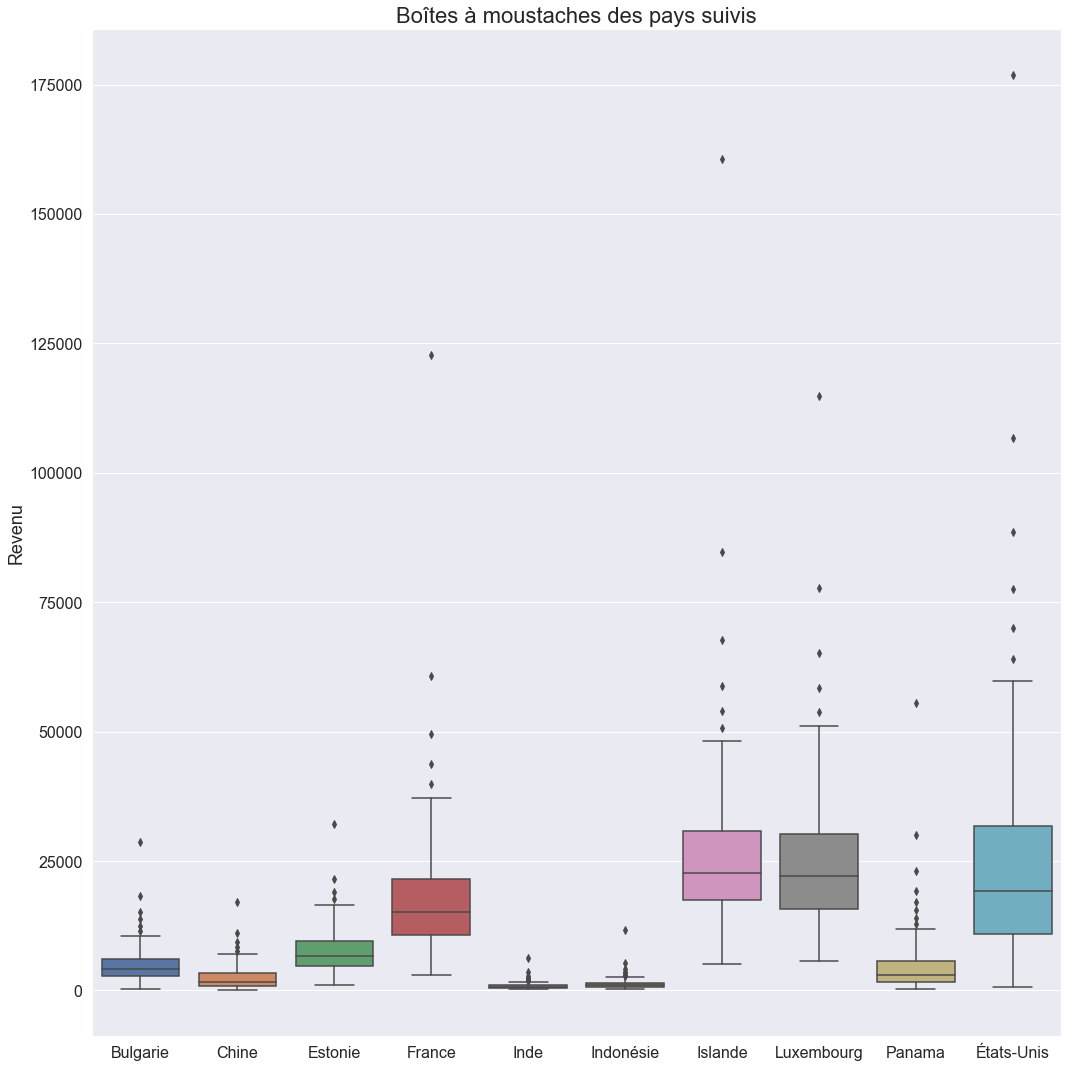

In [151]:
# Affichage des pays suivis
data_distri = data_anova.loc[(data_anova['pays'] == 'France') | (data_anova['pays'] == 'Bulgarie') |
                          (data_anova['pays'] == 'Estonie') | (data_anova['pays'] == 'Chine') |
                          (data_anova['pays'] == 'Luxembourg') | (data_anova['pays'] == 'Panama')|
                          (data_anova['pays'] == 'Indonésie') | (data_anova['pays'] == 'Islande')|
                          (data_anova['pays'] == 'Inde') | (data_anova['pays'] == 'États-Unis')]

plt.figure(figsize=(15,15))

ax = sn.boxplot(x='pays', y='income', data=data_distri)

plt.ylabel('Revenu', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=16)
plt.title('Boîtes à moustaches des pays suivis', fontsize=22)

plt.tight_layout()

plt.savefig('graphiques/boxplot_annova.png')
plt.show()

* Les variances des revenus des pays sélectionnées sont très différentes et inégales 

## ANOVA 
Avec pour variable explicative le pays

In [152]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

anova_pays = ols('income~pays', data=data_anova).fit()


In [153]:
anova_pays.summary().tables[0]

Dep. Variable:,income,R-squared:,0.494
Model:,OLS,Adj. R-squared:,0.489
Method:,Least Squares,F-statistic:,97.62
Date:,"Sat, 05 Feb 2022",Prob (F-statistic):,0.00
Time:,03:55:58,Log-Likelihood:,-1.1667e+05
No. Observations:,11400,AIC:,2.336e+05
Df Residuals:,11286,BIC:,2.344e+05
Df Model:,113,,
Covariance Type:,nonrobust,,


In [154]:
#print(anova_pays.summary())

In [155]:
# Test de Fisher                
test_f = sm.stats.anova_lm(anova_pays, typ=2)
print(test_f)


                sum_sq       df          F  PR(>F)
pays      5.057486e+11    113.0  97.618882     0.0
Residual  5.174430e+11  11286.0        NaN     NaN


- Interprétation du test de Fischer
<br/>

Rappel:
* H0: alpha de tout les pays = 0 => le pays n'a pas d'influence sur le revenu
* H1: les alpha des pays sont différents : Le pays a une influence sur le revenu des individus

La P_value du test de Fisher est = 0.0
au niveau de test de 5% nous rejettons donc HO.
**conclusion: Le pays a une influence sur le revenu**



In [156]:
#Calculons la variance expliquée du revenu
SCE=test_f.iloc[0,0]
SCR=test_f.iloc[1,0]
variab_pays=SCE/(SCE+SCR)
print('le paramètre beta_pays de la variable pays explique {} % de la variance des revenu des enfants'. format(variab_pays*100))

le paramètre beta_pays de la variable pays explique 49.428536419669676 % de la variance des revenu des enfants


#### Vérification de l'hypothèse gaussienne

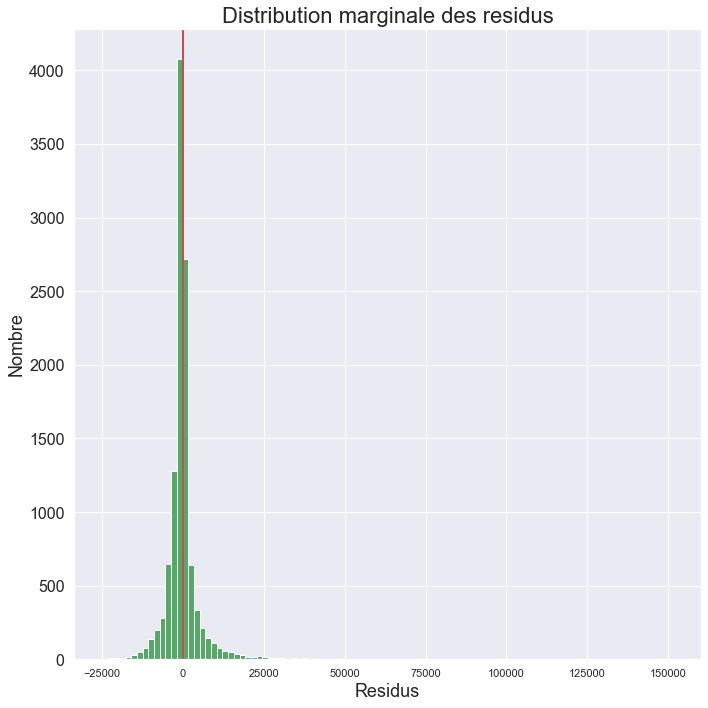

In [157]:
# Préparation des données
X = anova_pays.resid
Xbar = np.mean(X)
Xsprime = np.std(X)

#Représentation de la distribution marginale
plt.figure(figsize=(10,10))

plt.hist(X, 100, facecolor='g')
plt.axvline(Xbar, color='r', linewidth=2)

plt.title(f'Distribution marginale des residus', fontsize=22)
plt.ylabel('Nombre',fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Residus',fontsize=18)
plt.yticks(fontsize=16)

plt.tight_layout()

plt.savefig('graphiques/dist_marg_resid_anova.png')
plt.show()

#### Test de Kolmogorov Smirnov

In [158]:
# Test d'adequation à une loi (ici Normale) avec le test Kolmogorov-Smirnov
# import scipy.stats as st
from scipy.stats import t, shapiro, ks_2samp
ks_2samp(X,list(np.random.normal(Xbar, Xsprime, 11400)))

KstestResult(statistic=0.24535087719298243, pvalue=1.2222397108107154e-302)

- H0: Les données suivent une loi normale
- H1: Les données ne suivent pas une loi normale
<br\
p_value <<< 0.05, on rejette H0
**On conclut que les revenus des enfants (income) ne suivent pas une loi normale(Xbar, Xsprime)**

### Régression linéaire sur les données
#### Regression 1 : expliquons le revenus enfants avec:

- Revenu moyen du pays de l’individu (mj)
- Indice de Gini du pays de l’individu (Gj)

In [161]:
# groupons nos individus suivant les pays pour créer les revenus moyens
Data_1 = big_data.copy()
Data_2 =Data_1.groupby('pays').mean().reset_index()[["pays","income"]]

In [162]:
# créons une table contenant les revenus des individus et les revenus moyens
Data_3 = pd.merge(Data_1,Data_2, on = 'pays',suffixes=('_normal', '_moyenne'))
Data_3.columns

Index(['pays', 'quantile', 'income_normal', 'gini', 'coef_elast', 'Ci_parent',
       'income_moyenne'],
      dtype='object')

In [163]:
# renommons certaines variables
Data_3.rename(columns={"income_normal": "y_child", "income_moyenne": "mj", "gini": "Gj", "coef_elast":"pj"},inplace = True)

# aggrégeons nos données 
Data_regression = Data_3.groupby(by=['pays',
                                  'y_child',
                                  'mj',
                                  'Gj',
                                  'pj']).mean()

In [164]:
Data_regression .reset_index(inplace=True)
Data_regression .drop(columns=['Ci_parent'], inplace=True)

In [165]:
# Nous sommes dans un cas de regression multiple 
reg_multi = ols('y_child~mj+Gj', data=Data_regression).fit()
print(reg_multi.summary())


                            OLS Regression Results                            
Dep. Variable:                y_child   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     5570.
Date:                Sat, 05 Feb 2022   Prob (F-statistic):               0.00
Time:                        03:56:33   Log-Likelihood:            -1.1667e+05
No. Observations:               11400   AIC:                         2.333e+05
Df Residuals:                   11397   BIC:                         2.334e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.604e-12    334.956  -1.37e-14      1.0

**Test global:**
<br/>

- H0: beta_Gj = beta_mj = 0 => Modèle non significatif
- H1: beta_Gj != beta_mj != 0 => Modèle significatif
* F ~ 0.00 <<< alpha (0,5), on rejette H0, le modèle est donc globalement significatif

In [166]:
# Affichons le test de fisher
sm.stats.anova_lm(reg_multi, typ=2)

,sum_sq,df,F,PR(>F)
mj,4.389731e+11,1.0,9.668653e+03,0.0
Gj,3.661517e-22,1.0,8.064716e-30,1.0
Residual,5.174430e+11,11397.0,NaN,NaN


**Test sur la significativité des variables**
<br/>

**pour l'indice de gini**
- H0: beta_Gj = 0
- H1: beta_Gj != 0
<br/>

Le paramètre beta_Gj de la variable Gj (indice de gini) n'est pas significatif au niveau de test alpha (0.05).
En effet p-value ~ 1 > alpha, on accepte H0, le paramètre n'est pas significatif (beta_Gj = 0)
<br/>

**pour le revenu moyen des pays**
- H0: beta_mj = 0
- H1: beta_mj != 0
<br/>

Le paramètre beta_mj de la variable mj (revenu moyen du pays) est significatif au niveau de test alpha (0.05).
car p-value ~ 0.00 <<< alpha, on rejette H0, le paramètre est significatif (beta_mj != 0)

In [167]:
# Calculons la variance expliquée par le revenu moyen
analyse1=sm.stats.anova_lm(reg_multi, typ=2)

SCE_mj= analyse1.iloc[0,0]
SCR = analyse1.iloc[2,0]
var_mj = SCE_mj/(SCE_mj+SCR)

# Calculons la variance expliquée par le revenu moyen
SCE_Gj= analyse1.iloc[1,0]
SCR = analyse1.iloc[2,0]
var_Gj = SCE_Gj/(SCE_Gj+SCR)


print("variance expliquée par la variable mj: {}". format(var_mj*100))
print("variance expliquée par la variable Gj: {}". format(var_Gj*100))

print( 'la variance totale expliquée par notre modèle est de {}'.format((var_mj+var_Gj)* 100 ))

variance expliquée par la variable mj: 45.89771294118709
variance expliquée par la variable Gj: 7.076174569321075e-32
la variance totale expliquée par notre modèle est de 45.89771294118709


#### Regression logistique avec le log

In [168]:
# Mettons les revenus en logarithme
data_regression_log = Data_regression.copy()
data_regression_log['log_y_child'] = np.log(data_regression_log['y_child'])
data_regression_log['log_mj'] = np.log(data_regression_log['mj'])

In [169]:

reg_multi_log = ols('log_y_child~log_mj+Gj', data=data_regression_log).fit()
print(reg_multi_log.summary())


                            OLS Regression Results                            
Dep. Variable:            log_y_child   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                 1.526e+04
Date:                Sat, 05 Feb 2022   Prob (F-statistic):               0.00
Time:                        03:57:17   Log-Likelihood:                -12452.
No. Observations:               11400   AIC:                         2.491e+04
Df Residuals:                   11397   BIC:                         2.493e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4963      0.066      7.518      0.0

**Test global**
<br/>

- HO: Beta_Gj = Beta_log_mj = 0
- H1: Beta_Gj != Beta_log_mj ! = 0
<br/>

F ~ 0.00 <<< alpha, on rejette H0, le modèle est globalement significatif

In [170]:
sm.stats.anova_lm(reg_multi_log, typ=2)

,sum_sq,df,F,PR(>F)
log_mj,13480.015363,1.0,25901.534668,0.000000e+00
Gj,228.186117,1.0,438.454294,1.461442e-95
Residual,5931.375768,11397.0,NaN,NaN


**Test de significativité des variables**

- H0: Beta_Gj = 0
- H1: Beta_Gj != 0
<br/>

Le paramètre Beta_Gj de la variable Gj (indice de gini) est significatif au niveau de test alpha (0.05).
En effet p_value ~ 0.00 <<< alpha, on rejette H0, le paramètre est significatif (Beta_Gj != 0)
<br/>

- H0: Beta_log_mj = 0
- H1: Beta_log_mj != 0
<br/>

Le paramètre Beta_log_mj de la variable log_mj est significatif au niveau de test alpha (0.05)
En effet p_value ~ 0.00 <<< alpha, on rejette H0, le paramètre est significatif (Beta_log_mj != 0)

In [171]:
# calculons le pourcentage de variance expliquée par l'indice de Gini et par le log du revenu moyen' du revenu moyen  

analyse1_log=sm.stats.anova_lm(reg_multi_log, typ=2)

# Calcul de la variance expliqué par la variable 'Gj'
var_Gj = analyse1_log.sum_sq['Gj'] / analyse1_log['sum_sq'].sum()
var_Gj

#variance expliquée par log_mj
var_log_mj = analyse1_log.sum_sq['log_mj'] / analyse1_log['sum_sq'].sum()
var_log_mj

print('La variable Gj explique {} % de la variance de la variable log_y_child'.format(var_Gj*100))

print('La variable var_log_mj explique {} % de la variance de la variable log_y_child'.format(var_log_mj*100))

print('Notre modèle explique donc {} % de la variance de la variable log_y_child'.format((var_Gj+var_log_mj)*100))

La variable Gj explique 1.1618687811282888 % de la variance de la variable log_y_child
La variable var_log_mj explique 68.63699351946862 % de la variance de la variable log_y_child
Notre modèle explique donc 69.7988623005969 % de la variance de la variable log_y_child


In [172]:
# Vérifions que notre résultat concorde 
var_Gj + var_log_mj, reg_multi_log.rsquared

(0.697988623005969, 0.7280784108733696)

Différence observé entre la variance expliquée calculée et le coefficient de détermination.
* Ces derniers se rapprochent tout de même de 1 donc notre modèle serait assez fiable

### Analysons  l'atypicité sur les variables explicatives

In [173]:
# Paramètre de l'analyse
# Niveau de test pris en compte
alpha = 0.05

# Le nombre de l'échantillon
n = data_regression_log.shape[0]

# le nombre de variable
p= 3

# Seuil levier selon Belsey
seuil_levier = 2*p/n

In [174]:
print(n)

11400


In [175]:
print(seuil_levier)

0.0005263157894736842


#### Calculons les leviers

In [176]:
# Ajout des termes diagonaux de H
data_regression_log['levier'] = reg_multi_log.get_influence().hat_matrix_diag

data_regression_log.sort_values(by='levier', ascending=False).head(4)


,pays,y_child,mj,Gj,pj,quantile,log_y_child,log_mj,levier
0,Afrique du Sud,60.490383,5617.90488,0.682949,0.677,1.0,4.102484,8.633714,0.001168
1,Afrique du Sud,138.341550,5617.90488,0.682949,0.677,2.0,4.929726,8.633714,0.001168
3,Afrique du Sud,236.994000,5617.90488,0.682949,0.677,4.0,5.468035,8.633714,0.001168
51,Afrique du Sud,2181.245000,5617.90488,0.682949,0.677,52.0,7.687651,8.633714,0.001168


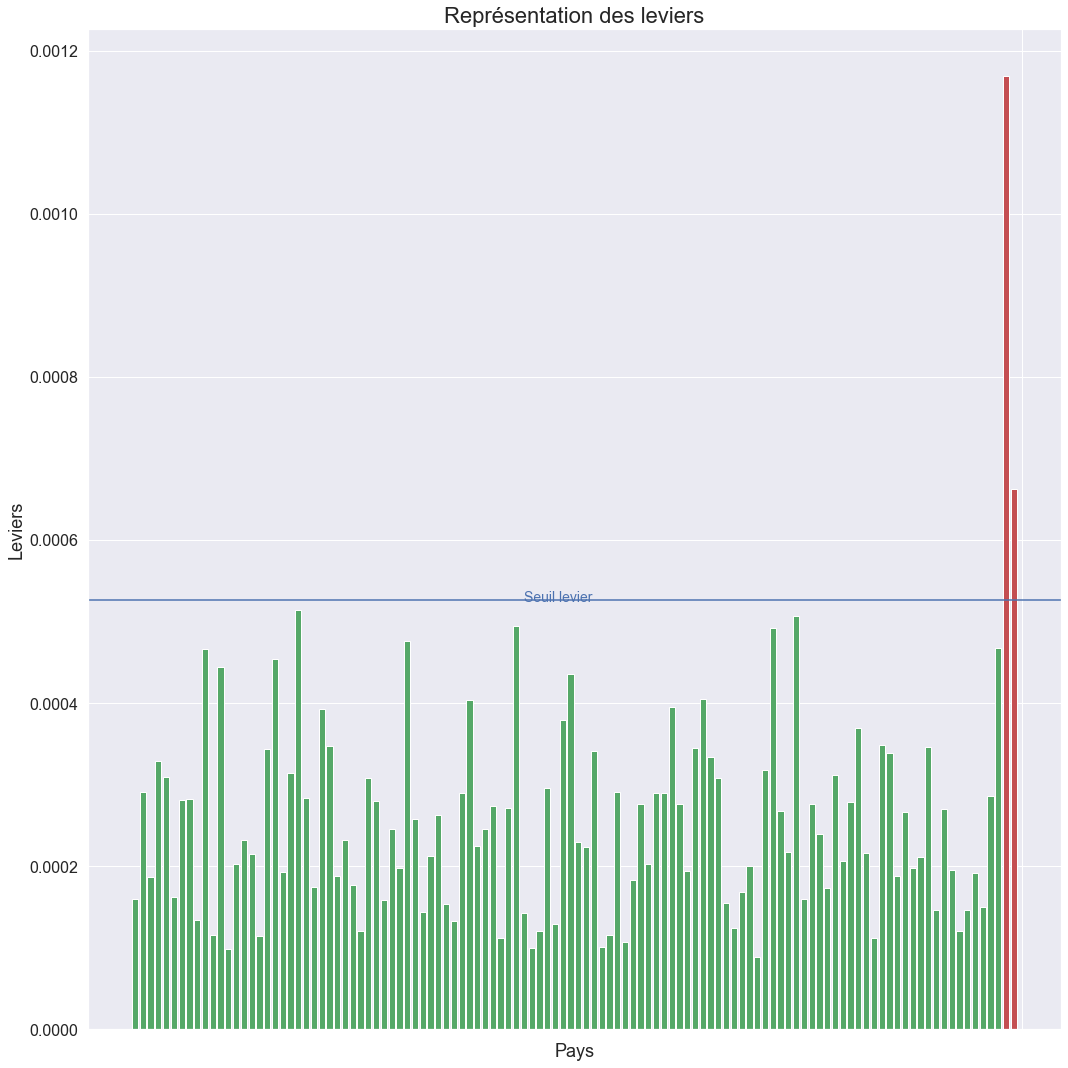

In [177]:
# Représentation des leviers
plt.figure(figsize=(15,15))

# Individus sous le seuil
plt.bar(data_regression_log.loc[data_regression_log['levier'] <= seuil_levier]['pays'],
        data_regression_log.loc[data_regression_log['levier'] <= seuil_levier]['levier'], color='g')

# Individus au dessus du seuil
plt.bar(data_regression_log.loc[data_regression_log['levier'] > seuil_levier]['pays'],
        data_regression_log.loc[data_regression_log['levier'] > seuil_levier]['levier'], color='r')

# Décoration et annotations
plt.title('Représentation des leviers', fontsize=22)
plt.xlabel('Pays', fontsize=18)
plt.xticks('', fontsize=16)
plt.ylabel('Leviers', fontsize=18)
plt.yticks(fontsize=16)
plt.axhline(y=seuil_levier, color='b', linestyle='-')
plt.text(50, 0.000525 , 'Seuil levier', fontsize = '14', color='b')
plt.tight_layout()

plt.savefig('graphiques/leviers1.png')
plt.show()

In [178]:
# Nombre de valeurs atypiques sur les variables explicatives
lev_ln = data_regression_log.loc[data_regression_log['levier'] > seuil_levier, :]
len(lev_ln)

200

In [179]:
# Pays présentants des valeurs atypiques
data_regression_log.loc[data_regression_log['levier'] > seuil_levier]

,pays,y_child,mj,Gj,pj,quantile,log_y_child,log_mj,levier
0,Afrique du Sud,60.490383,5617.904880,0.682949,0.677000,1.0,4.102484,8.633714,0.001168
1,Afrique du Sud,138.341550,5617.904880,0.682949,0.677000,2.0,4.929726,8.633714,0.001168
2,Afrique du Sud,192.294500,5617.904880,0.682949,0.677000,3.0,5.259028,8.633714,0.001168
3,Afrique du Sud,236.994000,5617.904880,0.682949,0.677000,4.0,5.468035,8.633714,0.001168
4,Afrique du Sud,279.367580,5617.904880,0.682949,0.677000,5.0,5.632528,8.633714,0.001168
...,...,...,...,...,...,...,...,...,...
3995,Honduras,10820.309000,3296.268419,0.615512,0.940737,96.0,9.289180,8.100546,0.000663
3996,Honduras,12523.644000,3296.268419,0.615512,0.940737,97.0,9.435374,8.100546,0.000663
3997,Honduras,15031.881000,3296.268419,0.615512,0.940737,98.0,9.617929,8.100546,0.000663
3998,Honduras,19564.543000,3296.268419,0.615512,0.940737,99.0,9.881474,8.100546,0.000663


- **L'Afrique du Sud** et **l'Honduras** sont les pays où l'on retrouve des valeurs atypiques

In [180]:
data_regression_log.sort_values(by='levier', ascending=False).head()

,pays,y_child,mj,Gj,pj,quantile,log_y_child,log_mj,levier
0,Afrique du Sud,60.490383,5617.90488,0.682949,0.677,1.0,4.102484,8.633714,0.001168
1,Afrique du Sud,138.341550,5617.90488,0.682949,0.677,2.0,4.929726,8.633714,0.001168
3,Afrique du Sud,236.994000,5617.90488,0.682949,0.677,4.0,5.468035,8.633714,0.001168
51,Afrique du Sud,2181.245000,5617.90488,0.682949,0.677,52.0,7.687651,8.633714,0.001168
73,Afrique du Sud,4840.149400,5617.90488,0.682949,0.677,74.0,8.484701,8.633714,0.001168


#### Calculez les résidus studentisés

Le calcul des résidus studentisés permet aussi de détecter les outliers.
<br/>
- Notons que le seuil pour les résidus studentisés est une lois de student à n-p-1 degré de liberté. 

In [181]:
# Détermination du seuil statistique d'atypicité
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)
print('Le seuil statistique (seuil_rstudent) est :{}'. format(seuil_rstudent))

Le seuil statistique (seuil_rstudent) est :1.9601721732838657


In [182]:
# statistique de test par observation
data_regression_log['rstudent'] = reg_multi_log.get_influence().resid_studentized_internal
data_regression_log.sort_values(by='rstudent').head()

,pays,y_child,mj,Gj,pj,quantile,log_y_child,log_mj,levier,rstudent
9000,République de Corée,17.317732,15227.569445,0.367935,0.394000,1.0,2.851731,9.630863,0.000239,-9.061264
1800,Canada,122.424810,23739.640518,0.366553,0.269333,1.0,4.807497,10.074902,0.000343,-6.960634
2000,Chine,16.719418,2522.758726,0.493332,0.399000,1.0,2.816571,7.833108,0.000193,-6.364229
1000,Bolivie,20.584948,3016.263843,0.575719,0.866268,1.0,3.024560,8.011774,0.000466,-6.132282
4600,Israël,142.350430,11100.318137,0.429918,0.346163,1.0,4.958292,9.314729,0.000225,-5.566507


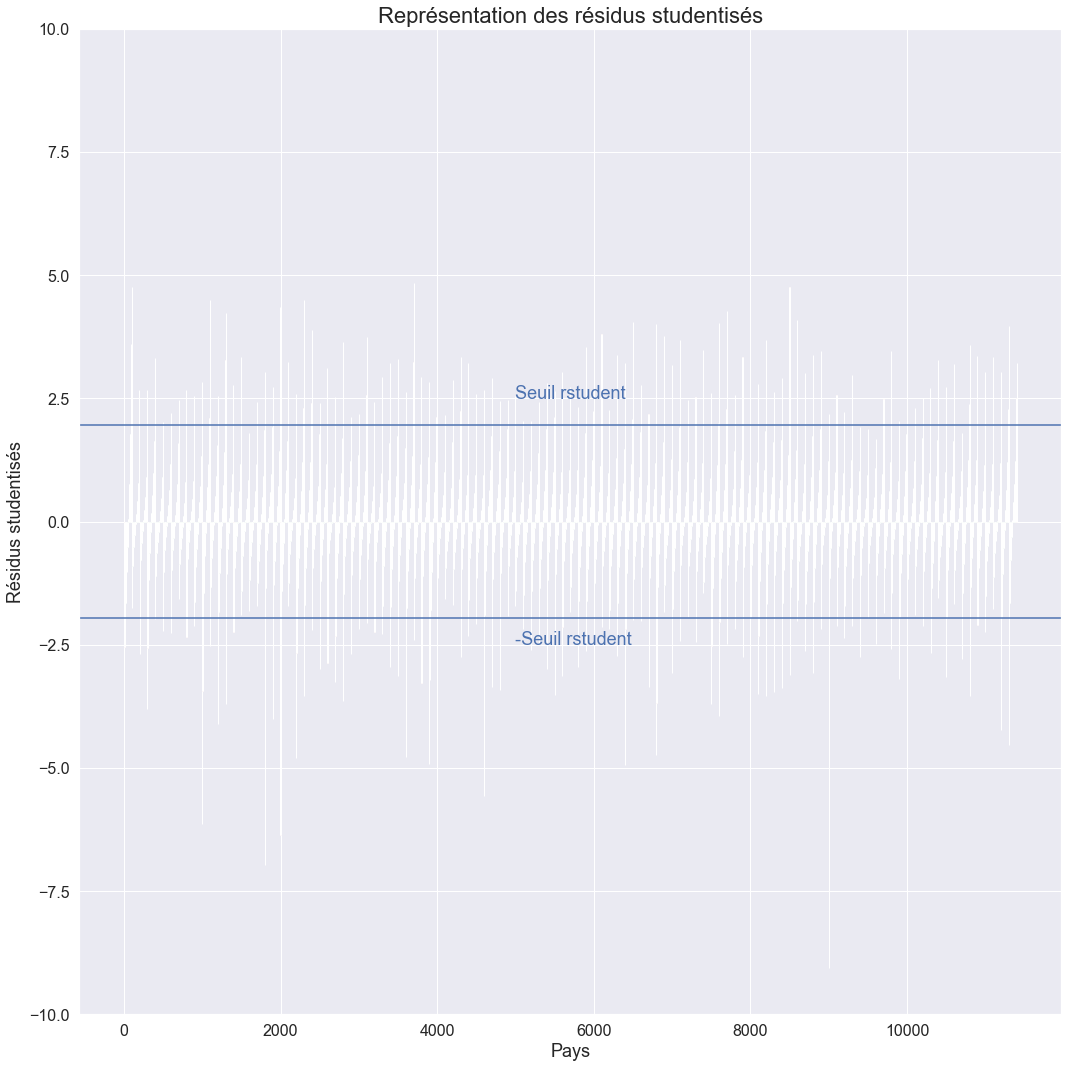

In [183]:
database1 = data_regression_log.groupby(['pays', 'mj', 'Gj', 'pj', 'log_mj', 'rstudent']).mean()
database1.reset_index(inplace=True)

# Représentation des leviers
plt.figure(figsize=(15,15))

# Individus entre le seuil mini et le seuil maxi
plt.bar(database1.loc[(database1['rstudent'] <= seuil_rstudent) & (database1['rstudent'] >= -seuil_rstudent)].index,
        database1.loc[(database1['rstudent'] <= seuil_rstudent) & (database1['rstudent'] >= -seuil_rstudent)]['rstudent'], color='g')

# Individus au dessus du seuil maxi
plt.bar(database1.loc[database1['rstudent'] > seuil_rstudent].index,
        database1.loc[database1['rstudent'] > seuil_rstudent]['rstudent'], color='r')

# Individus au dessous du seuil maxi
plt.bar(database1.loc[database1['rstudent'] < -seuil_rstudent].index,
        database1.loc[database1['rstudent'] < -seuil_rstudent]['rstudent'], color='r')

# mise en forme du graphique
plt.title('Représentation des résidus studentisés', fontsize=22)
plt.xlabel('Pays', fontsize=18)
plt.xticks(fontsize=16)
plt.ylim(-10,10)
plt.ylabel('Résidus studentisés', fontsize=18)
plt.yticks(fontsize=16)

plt.axhline(y=seuil_rstudent, color='b', linestyle='-')
plt.text(5_000, 2.5 , 'Seuil rstudent', fontsize = '18', color='b')

plt.axhline(y=-seuil_rstudent, color='b', linestyle='-')
plt.text(5_000, -2.5 , '-Seuil rstudent', fontsize = '18', color='b')

plt.tight_layout()

plt.savefig('graphiques/res_stu.png', dpi=300)
plt.show()

In [189]:
# Sélectionnons les individus pour lesquels le levier est supérieur au seuil_levier
levier=data_regression_log.loc[data_regression_log['levier'] > seuil_levier, :]

##### Analyse de l'influence des observations
<br/>

Existe t-il des variables qui influences grandement notre modèle 

In [190]:
np.set_printoptions(suppress=True)

#create instance of influence
influence_ln = reg_multi_log.get_influence().summary_frame()
influence_ln.head()

,dfb_Intercept,dfb_log_mj,dfb_Gj,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,0.127459,-0.068192,-0.171324,0.010725,-5.244442,0.001168,-0.179371,-5.250551,-0.179580
1,0.099527,-0.053248,-0.133779,0.006545,-4.097071,0.001168,-0.140128,-4.099912,-0.140226
2,0.088418,-0.047305,-0.118847,0.005167,-3.640334,0.001168,-0.124507,-3.642293,-0.124574
3,0.081370,-0.043534,-0.109373,0.004377,-3.350445,0.001168,-0.114592,-3.351949,-0.114644
4,0.075824,-0.040567,-0.101919,0.003801,-3.122295,0.001168,-0.106789,-3.123494,-0.106830


In [191]:
# Ajoutons la colonne distance de Cook à notre dataframe data_regression_log
data_regression_log['dcooks'] = influence_ln['cooks_d']

# Seuil d'influence selon Cook
seuil_dcook = 4/(n-p)

data_regression_log.sort_values(by='dcooks').head()

,pays,y_child,mj,Gj,pj,quantile,log_y_child,log_mj,levier,rstudent,dcooks
9951,Swaziland,362.52875,530.283828,0.478735,0.629976,52.0,5.893104,6.273412,0.000339,0.000094,9.961274e-13
1452,Burkina Faso,693.67725,917.952658,0.413469,0.673630,53.0,6.542007,6.822146,0.000202,-0.000203,2.774494e-12
10151,Taïwan,13724.78200,16500.223670,0.331487,0.181000,52.0,9.526958,9.711129,0.000266,-0.000404,1.447166e-11
8954,République Tchèque,7657.33450,8235.293411,0.270162,0.434041,55.0,8.943419,9.016184,0.000277,0.000408,1.532343e-11
6153,Mali,576.89970,681.075039,0.346782,0.713953,54.0,6.357668,6.523672,0.000342,-0.000402,1.843697e-11


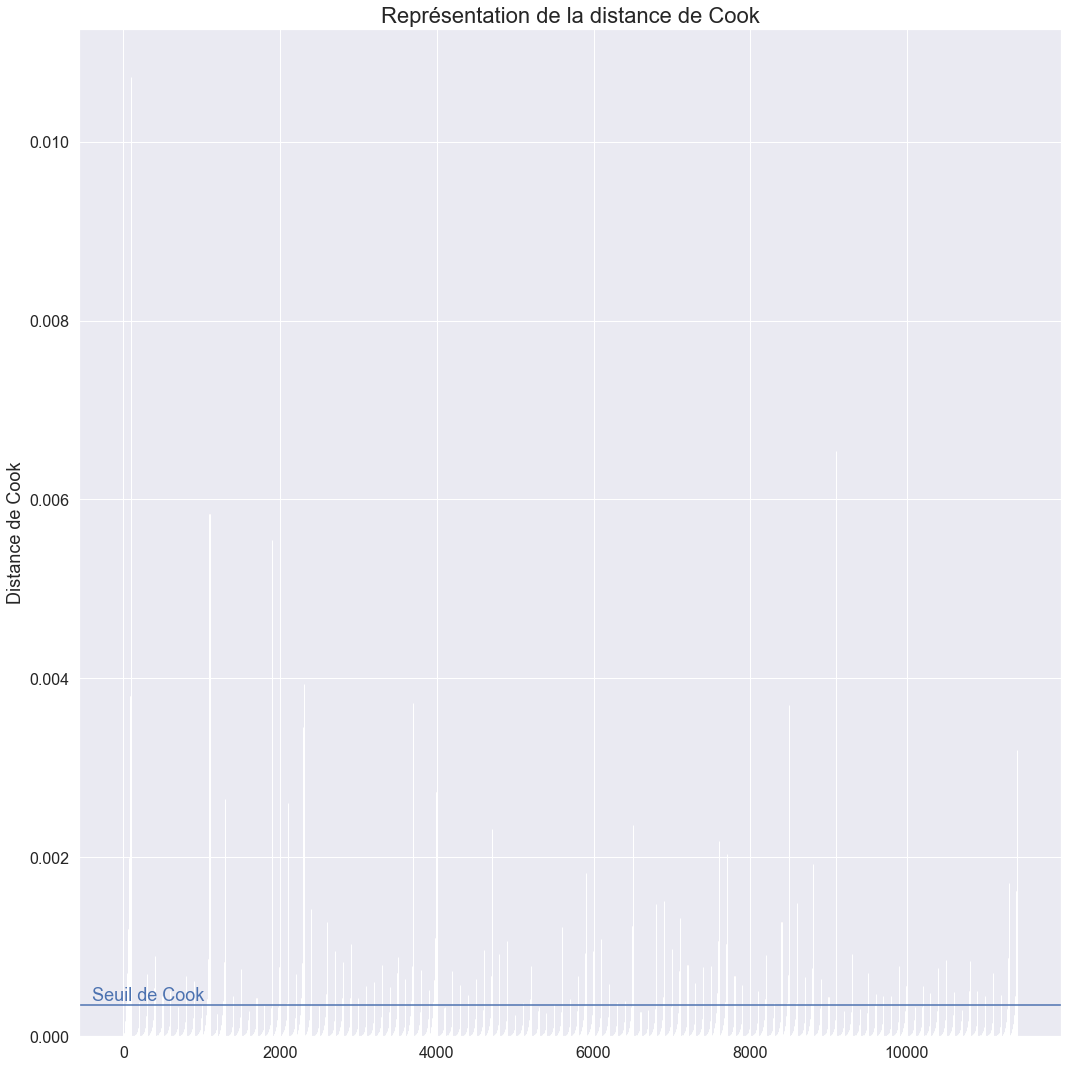

In [192]:
database2 = data_regression_log.groupby(['pays', 'mj', 'Gj', 'pj', 'log_mj', 'dcooks']).mean()
database2.reset_index(inplace=True)

# Représentation de la distances de Cooks
plt.figure(figsize=(15,15))

# Individus sous le seuil
plt.bar(database2.loc[database2['dcooks'] <= seuil_dcook].index,
        database2.loc[database2['dcooks'] <= seuil_dcook]['dcooks'],
       color='g')

# Individus au dessus le seuil
plt.bar(database2.loc[database2['dcooks'] > seuil_dcook].index,
        database2.loc[database2['dcooks'] > seuil_dcook]['dcooks'],
       color='r')

# Décoration et annotations
plt.title('Représentation de la distance de Cook', fontsize=22)
plt.ylabel('Distance de Cook', fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.text(-400, (seuil_dcook + 0.00005), 'Seuil de Cook', fontsize = '18', color='b')
plt.axhline(y=seuil_dcook, color='b', linestyle='-')

plt.tight_layout()

plt.savefig('graphiques/dist_cook.png')
plt.show()

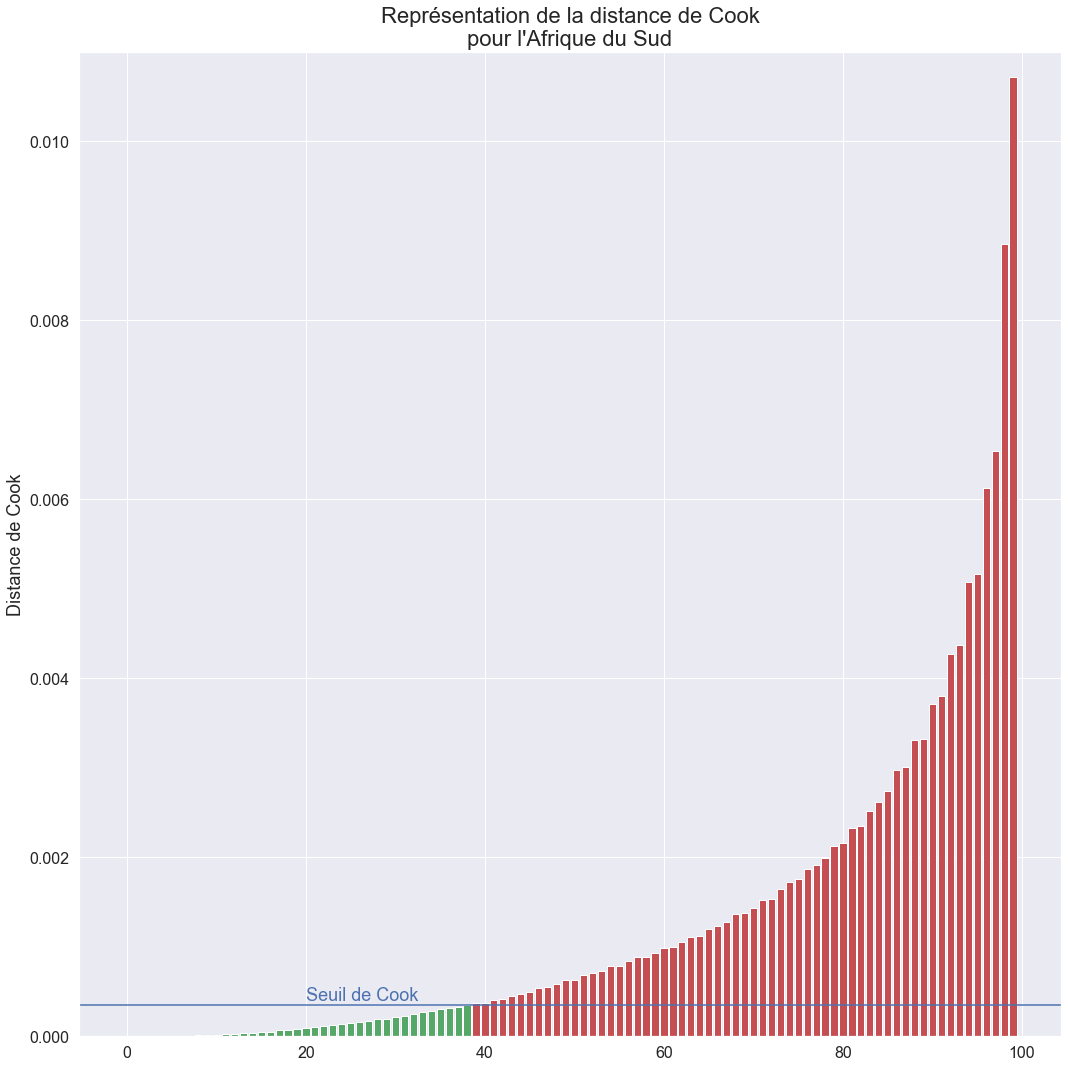

In [194]:
cook_saf1 = database2.loc[database2['pays'] == 'Afrique du Sud']
cook_saf1.reset_index(inplace=True)

# Représentation de la distances de Cooks
plt.figure(figsize=(15,15))

# Individus sous le seuil
plt.bar(cook_saf1.loc[cook_saf1['dcooks'] <= seuil_dcook].index,
        cook_saf1.loc[cook_saf1['dcooks'] <= seuil_dcook]['dcooks'],
       color='g')

# Individus au dessus le seuil
plt.bar(cook_saf1.loc[cook_saf1['dcooks'] > seuil_dcook].index,
        cook_saf1.loc[cook_saf1['dcooks'] > seuil_dcook]['dcooks'],
       color='r')

# Décoration et annotations
plt.title('Représentation de la distance de Cook\npour l\'Afrique du Sud', fontsize=22)
plt.ylabel('Distance de Cook', fontsize=18)
plt.ylim(0,0.011)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.text(20, (seuil_dcook + 0.00005), 'Seuil de Cook', fontsize = '18', color='b')
plt.axhline(y=seuil_dcook, color='b', linestyle='-')

plt.tight_layout()

plt.savefig('graphiques/dist_cook_saf.png')
plt.show()

In [195]:
# Nombre d'observations influentes
dco_ln = data_regression_log.loc[data_regression_log['dcooks'] > seuil_dcook]
len(dco_ln)

648

In [196]:
# Pays présentants des obervations au dela du seuil
database2.loc[database2.index.isin(dco_ln.index)].groupby(by='pays').count().sort_values(by='y_child',
                                                                                         ascending=False)

,mj,Gj,pj,log_mj,dcooks,y_child,quantile,log_y_child,levier,rstudent
pays,,,,,,,,,,
Afrique du Sud,61,61,61,61,61,61,61,61,61,61
Honduras,44,44,44,44,44,44,44,44,44,44
Colombie,31,31,31,31,31,31,31,31,31,31
Bolivie,30,30,30,30,30,30,30,30,30,30
République Centrafricaine,26,26,26,26,26,26,26,26,26,26
...,...,...,...,...,...,...,...,...,...,...
Bulgarie,1,1,1,1,1,1,1,1,1,1
Mauritanie,1,1,1,1,1,1,1,1,1,1
Népal,1,1,1,1,1,1,1,1,1,1


##### Détectons les problèmes de colinéarité

In [197]:
# Facteur d'influence de la variance (Variance Inflation Factor)
mat_cor = np.corrcoef(data_regression_log.log_mj, data_regression_log.Gj)
1 / (1-(mat_cor[0,1]**2)), mat_cor[0,1]

(1.082211572747146, -0.27561978612259663)

Tous les Coefficients sont  << 10 : Pas de colinéarité problème de colinéarité

##### Test d'homoscédasticité

In [198]:
_, pval, __, f_pval = sm.stats.diagnostic.het_breuschpagan(reg_multi_log.resid, reg_multi_log.model.exog)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 4.584874196045764e-151


* H0: Homoscédasticité
* H1: Hétéroscédasticité
* pvalue <<< alpha, rejet de H0, il y a hétéroscédasticité des residus

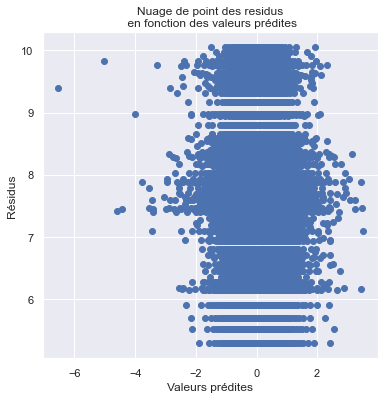

In [199]:
# Représentation des résidus en fonction des valeurs prédites
plt.figure(figsize=(6,6))

plt.scatter(reg_multi_log.resid, reg_multi_log.predict())

plt.ylabel('Résidus')
plt.xlabel('Valeurs prédites')
plt.title('Nuage de point des residus\n en fonction des valeurs prédites')

plt.savefig('graphiques/homoscedasticity.png')
plt.show()

##### Test de normalité des résidus

In [200]:
# Préparation des données
X_log = reg_multi_log.resid
Xbar_log = np.mean(X_log)
Xsprime_log = np.std(X_log)

# Test d'adequation à une loi (ici Normale) avec le test Kolmogorv-Smirnov
ks_2samp(reg_multi_log.resid, list(np.random.normal(Xbar_log, Xsprime_log, 11_400)))

KstestResult(statistic=0.0407894736842106, pvalue=1.119897250368853e-08)

- H0: Les données suivent une loi normale
- H1: Les données ne suivent pas une loi normale
- p_value <<< 0.05, on rejette H0, le revenu enfant (y_child) ne suit pas une loi normale

C:\Users\armel\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


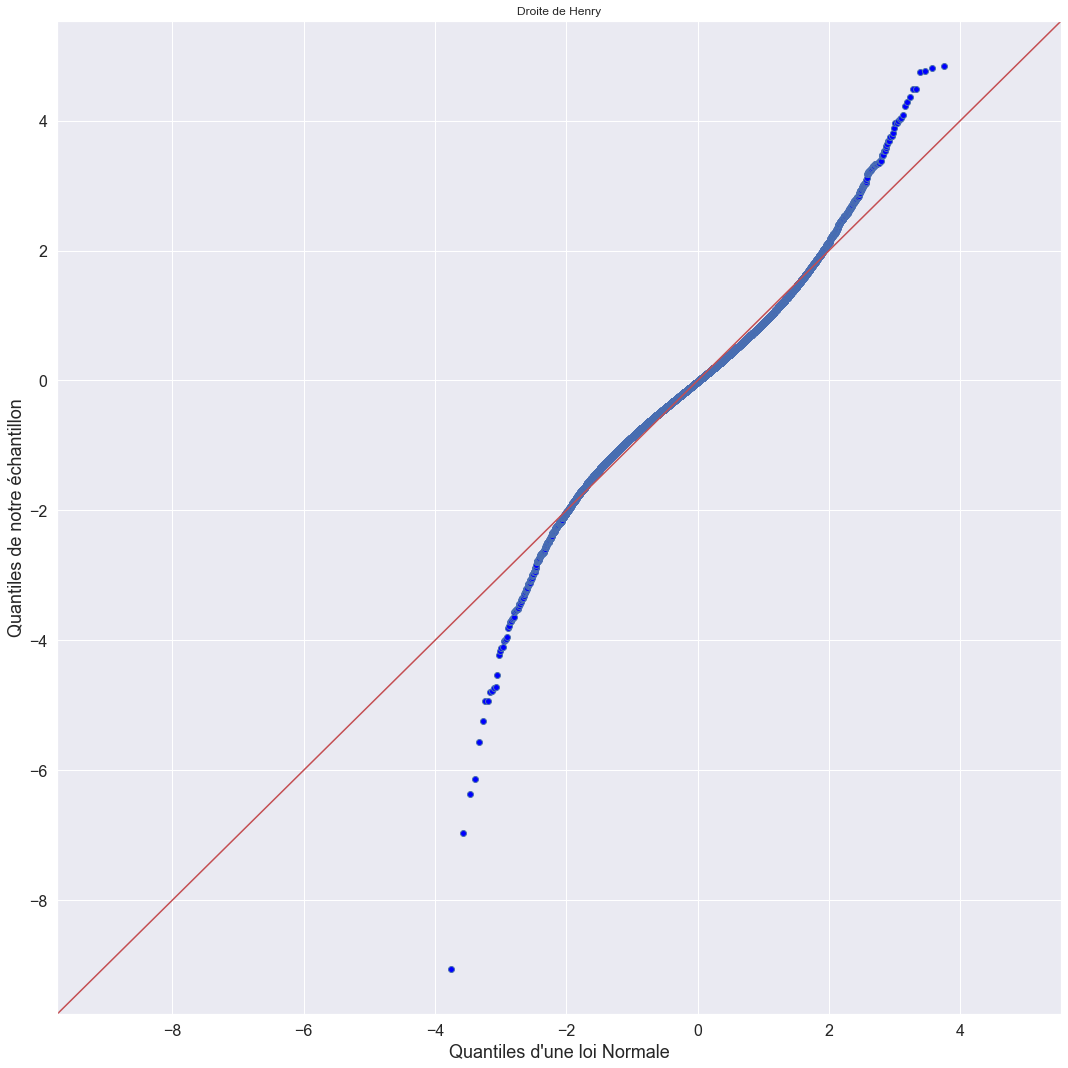

In [201]:
# Droite de Henry
fig, ax = plt.subplots(figsize=(15, 15))

sm.qqplot(reg_multi_log.resid, line='45', fit=True, ax=ax)

plt.ylabel('Quantiles de notre échantillon', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel("Quantiles d'une loi Normale", fontsize=18)
plt.xticks(fontsize=16)
plt.title('Droite de Henry')

plt.tight_layout()

plt.savefig('graphiques/droite_henry_reg1.png')
plt.show()

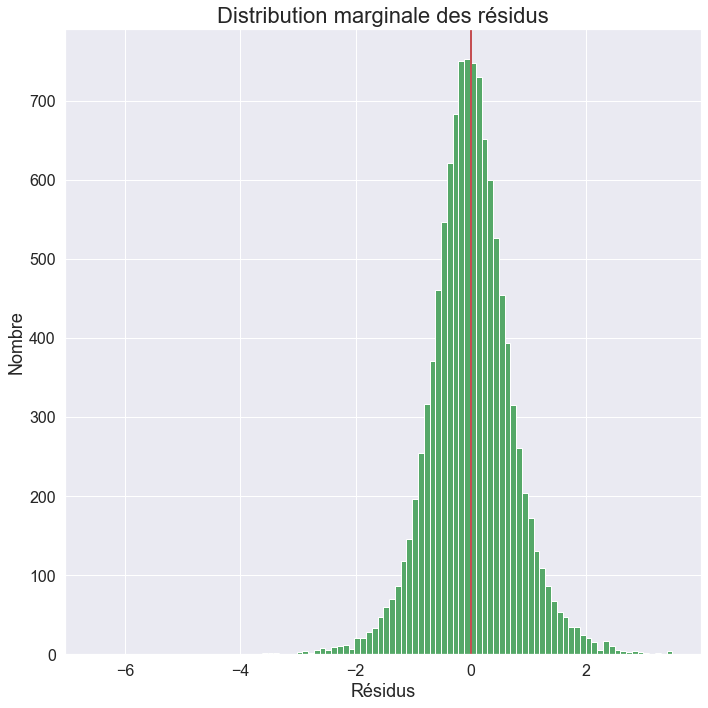

In [202]:
#Représentation de la distribution marginale
plt.figure(figsize=(10,10,))

plt.hist(X_log, 100, facecolor='g',)
plt.axvline(Xbar_log, color='r', linewidth=2)

plt.title(f'Distribution marginale des résidus', fontsize=22)
plt.ylabel('Nombre', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Résidus', fontsize=18)
plt.xticks(fontsize=16)

plt.tight_layout()

plt.savefig('graphiques/dist_marg_resid_reg1.png')
plt.show()

### Améliorons le modèle de regression linéaire en incluant la classe de revenu des parents.

In [203]:
# nous allons ajouter parmi nos variables explicatives la classe de revenu des parents

reg_multi_ameliore = ols('y_child~mj+Gj+Ci_parent', data=Data_3).fit()
print(reg_multi_ameliore.summary())


                            OLS Regression Results                            
Dep. Variable:                y_child   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                 2.059e+06
Date:                Sat, 05 Feb 2022   Prob (F-statistic):               0.00
Time:                        04:06:42   Log-Likelihood:            -5.8187e+07
No. Observations:             5700000   AIC:                         1.164e+08
Df Residuals:                 5699996   BIC:                         1.164e+08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2659.6385     15.364   -173.113      0.0

Test global:
- H0: beta_Gj = beta_mj = beta_c_i_parent = 0
- H1: beta_Gj != beta_mj = beta_c_i_parent != 0
- F ~ 0.00 <<< alpha, on rejette H0, le modèle est globalement significatif

In [204]:
sm.stats.anova_lm(reg_multi_ameliore, typ=2)

,sum_sq,df,F,PR(>F)
mj,2.194865e+14,1.0,5.095030e+06,0.0
Gj,8.009829e-13,1.0,1.859354e-20,1.0
Ci_parent,1.317385e+13,1.0,3.058098e+05,0.0
Residual,2.455476e+14,5699996.0,NaN,NaN


Test de significativité:

- H0: beta_Gj = 0
- H1: beta_Gj != 0
Le paramètre beta_gini de la variable gini (indice de gini) n'est pas significatif au niveau de test alpha (0.05)
En effet p-value ~ 1 > alpha, on accepte H0, le paramètre n'est pas significatif (beta_gini = 0)
<br/>

- H0: beta_mj = 0
- H1: beta_mj != 0
Le paramètre beta_income_moyenne de la variable income_moyenne est significatif au niveau de test alpha (0.05)
En effet p-value ~ 0.00 <<< alpha, on rejette H0, le paramètre est significatif (beta_income_moyenne != 0)
<br/>

- H0: beta_c_i_parent = 0
- H1: beta_c_i_parent != 0
Le paramètre beta_Ci_parent de la variable Ci_parent est significatif au niveau de test alpha (0.05)
En effet p-value ~ 0.00 <<< alpha, on rejette H0, le paramètre est significatif (beta_Ci_parent != 0

#### Variance expliquée par ce nouveau modèle 

In [205]:
# cas de regression avec revenu moyen du pays et les revenus (parents & enfants) en logarithme


# Mettons les revenus en logarithme
data_regression2log = Data_3.copy()
data_regression2log['log_y_child'] = np.log(data_regression2log['y_child'])
data_regression2log['log_mj'] = np.log(data_regression2log['mj'])

reg_multi_ameliore_log = ols('log_y_child~log_mj+Gj+Ci_parent', data=data_regression2log).fit()
print(reg_multi_ameliore_log.summary())

                            OLS Regression Results                            
Dep. Variable:            log_y_child   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                 6.861e+06
Date:                Sat, 05 Feb 2022   Prob (F-statistic):               0.00
Time:                        04:06:46   Log-Likelihood:            -5.5812e+06
No. Observations:             5700000   AIC:                         1.116e+07
Df Residuals:                 5699996   BIC:                         1.116e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0715      0.003    -26.684      0.0

**Test global:**
- H0: beta_Gj = beta_mj = beta_Ci_parent = 0
- H1: beta_Gj != beta_mj = beta_Ci_parent != 0
<br/>

F ~ 0.00 <<< alpha, on rejette H0, le modèle est globalement significatif

In [206]:
sm.stats.anova_lm(reg_multi_ameliore_log, typ=2)

,sum_sq,df,F,PR(>F)
log_mj,6.740008e+06,1.0,1.624243e+07,0.0
Gj,1.140931e+05,1.0,2.749475e+05,0.0
Ci_parent,6.004001e+05,1.0,1.446876e+06,0.0
Residual,2.365288e+06,5699996.0,NaN,NaN


In [207]:
# calculons uniquement la variance expliquée par la nouvelle variable (classe des parents)
analyse2_log=sm.stats.anova_lm(reg_multi_ameliore_log, typ=2)

# Calcul du R2 pour la variable 'Ci_parent'
var_Ci_parent = analyse2_log.sum_sq['Ci_parent'] / analyse2_log['sum_sq'].sum()
var_Ci_parent

print(' la variable classe_parent explique {}% de la variance de la variable y_child'.format(var_Ci_parent*100))

 la variable classe_parent explique 6.114185659005937% de la variance de la variable y_child


In [208]:
# Vérification
var_Gj + var_log_mj + var_Ci_parent, reg_multi_ameliore_log.rsquared

(0.7591304795960283, 0.783128624450051)

### Approfondissons les tests statistiques

#### - Détectons les problèmes de Colinéarité

In [209]:
# Facteur d'influence de la variance (Variance Inflation Factor)
variables_log2 = reg_multi_ameliore_log.model.exog
[variance_inflation_factor(variables_log2, i) for i in np.arange(1,variables_log2.shape[1])]

[1.0822115727471378, 1.0822115727473116, 0.9999999999999991]

#### - Test d'homoscédasticité

In [210]:
_, pval2, __, f_pval2 = sm.stats.diagnostic.het_breuschpagan(reg_multi_ameliore_log.resid, variables_log2)
print('p value test Breusch Pagan:', pval2)

p value test Breusch Pagan: 0.0


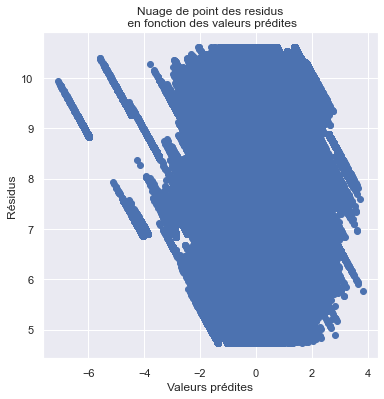

In [211]:
# Représentation des résidus en fonction des valeurs prédites
plt.figure(figsize=(6,6))

plt.scatter(reg_multi_ameliore_log.resid, reg_multi_ameliore_log.predict())

plt.ylabel('Résidus')
plt.xlabel('Valeurs prédites')
plt.title('Nuage de point des residus\n en fonction des valeurs prédites')

plt.savefig('graphiques/homoscedasticity2.png')
plt.show()

#### - Test de normalité des résidus

In [212]:
# Test d'adequation à une loi (ici Normale) avec le test Kolmogorv-Smirnov
X_log2 = reg_multi_ameliore_log.resid
Xbar_log2 = np.mean(X_log2)
Xsprime_log2 = np.std(X_log2)

ks_2samp(reg_multi_ameliore_log.resid, list(np.random.normal(Xbar_log2, Xsprime_log2, 5_700_000)))

KstestResult(statistic=0.02746561403508771, pvalue=0.0)

* H0: Les données suivent une loi normale
* H1: Les données ne suivent pas une loi normale
* p-value <<< 0.05, on rejette H0, y_child ne suit pas une loi normale

C:\Users\armel\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


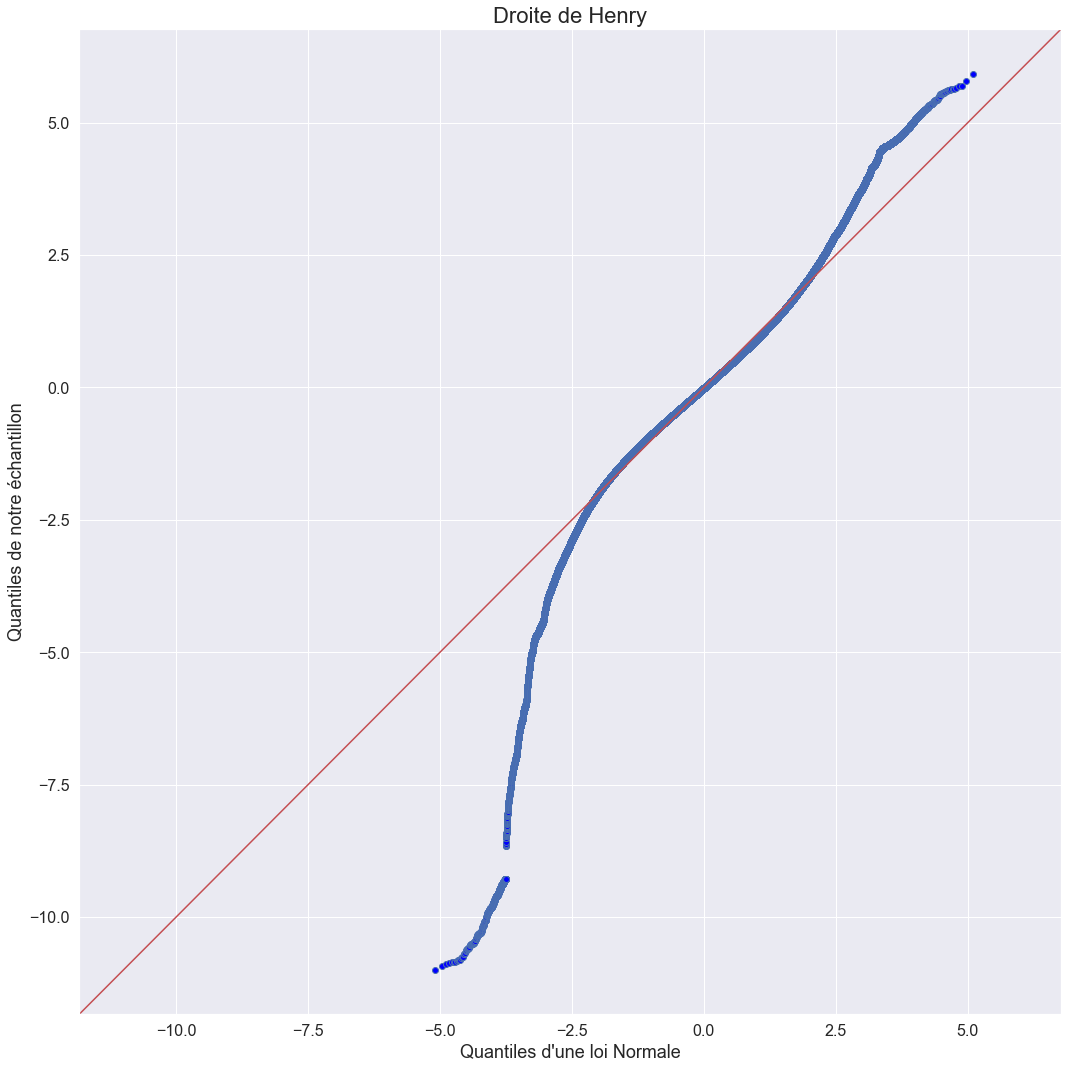

In [213]:
# Droite de Henry
fig, ax = plt.subplots(figsize=(15, 15))

sm.qqplot(X_log2, line='45', fit=True, ax=ax)

plt.ylabel('Quantiles de notre échantillon',fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Quantiles d\'une loi Normale',fontsize=18)
plt.xticks(fontsize=16)
plt.title('Droite de Henry',fontsize=22)

plt.tight_layout()

plt.savefig('graphiques/droite_henry_reg2.png')
plt.show()

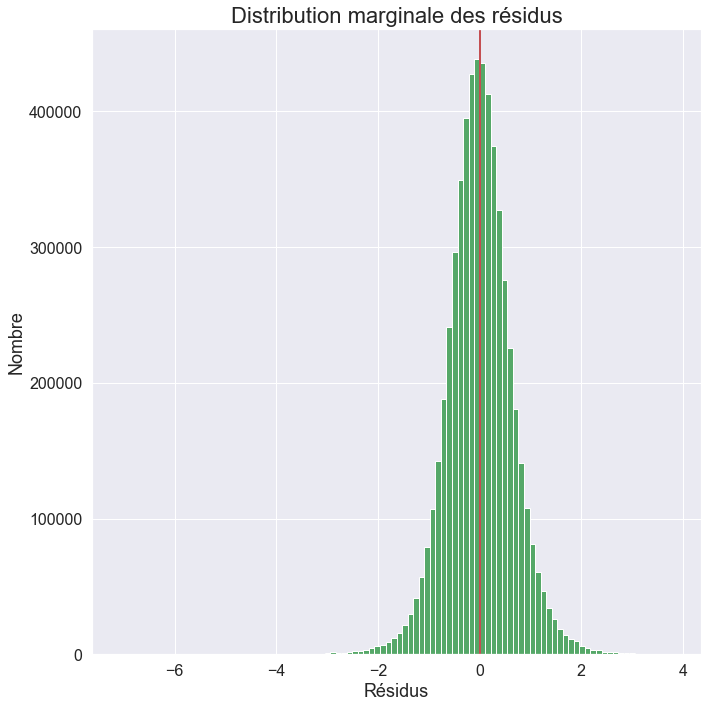

In [214]:
#Représentation de la distribution marginale
plt.figure(figsize=(10,10))

plt.hist(X_log2, 100, facecolor='g')
plt.axvline(Xbar_log2, color='r', linewidth=2)

plt.title(f'Distribution marginale des résidus', fontsize=22)
plt.ylabel('Nombre',fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Résidus', fontsize=18)
plt.xticks(fontsize=16)

plt.tight_layout()

plt.savefig('graphiques/dist_marg_resid_reg2.png')
plt.show()

### Influence de la transformation en log

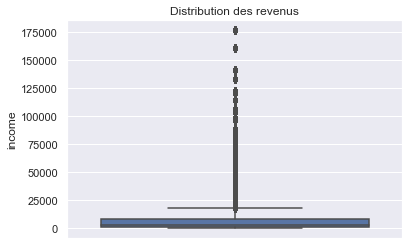

In [216]:
sn.boxplot( y=big_data["income"] )
plt. title('Distribution des revenus')
plt.savefig('graphiques/dist_revenus.png')
plt.show()

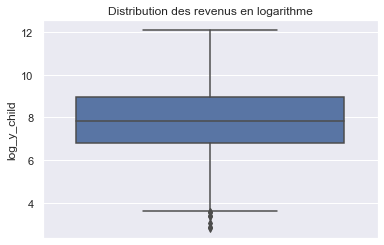

In [217]:
sn.boxplot( y=data_regression_log["log_y_child"] )

plt. title('Distribution des revenus en logarithme')
plt.savefig('graphiques/ dist_log_revenus.png')
plt.show()